This notebook implements a Pitch Control model based on the framework established by **Luke Bornn** and **Javier Fernández**.

Reference: https://www.lukebornn.com/papers/fernandez_ssac_2018.pdf

## Import Dependencies

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from mplsoccer import Pitch
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from scipy.ndimage import gaussian_filter
from scipy.stats import multivariate_normal as mvn
from scipy.interpolate import RegularGridInterpolator
from sklearn.cluster import KMeans

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This demonstration utilizes tracking data provided by SONY Hawk-Eye. Its industry-leading accuracy and high refresh rate are critical for high-fidelity spatial modeling.

Due to the strict Non-Disclosure Agreement (NDA) governing the use of this professional tracking data, the raw datasets are not included in this repository. To maintain the reproducibility of the code while respecting data privacy, the processing pipeline is designed to work with a standardized schema.

**Technical Specification**: The input `tracking data` has been pre-processed into the [Wyscout Specification](https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_setup/plot_pitch_types.html):
- Coordinates: Normalized to a **0−100 scale**.
- Origin: $(0,0)$ is located at the **top-left corner** of the pitch.
- Orientation: Data is aligned to the "attack-direction" standard where the x-axis represents the length and the y-axis represents the width.
- Temporal Resolution: All players and the ball are synchronized to a common frame rate of **50 Hz**.

In [ ]:
df = pd.read_csv("/path/to/sony_example_full_match_tracking_data.csv", low_memory=False)

| **Column Name** | **Data Type** | **Description** | **Values / Examples** |
| :--- | :--- | :--- | :--- |
| **`player`** | Integer | Unique ID for the entity (Player or Ball). | `0` (Ball), `2227`, `3315` |
| **`x`** | Float | Horizontal pitch coordinate (Wyscout scale). | `0.0` (Left) to `100.0` (Right) |
| **`y`** | Float | Vertical pitch coordinate (Wyscout scale). | `0.0` (Top) to `100.0` (Bottom) |
| **`possession_team`** | String | Team in control of the ball for this frame. | `'home'`, `'away'`, or `'None'` |
| **`frame`** | Integer | Global match clock index (50 fps). | `0` to `294538` |
| **`team`** | String | Team affiliation of the specific row's ID. | `'home'`, `'away'`, or `'ball'` |

In [ ]:
def force_possession_change(df, start_frame, end_frame, target_team):
    """
    Forcefully updates the possession_team for a specific frame range.
    
    Parameters:
    df (pd.DataFrame): The tracking dataframe.
    start_frame (int): The first frame of the sequence.
    end_frame (int): The last frame of the sequence.
    target_team (str): 'home', 'away', or 'None'.
    """
    
    # Ensure target_team is valid
    valid_teams = ['home', 'away', 'None']
    if target_team not in valid_teams:
        raise ValueError(f"target_team must be one of {valid_teams}")

    # Logic: Locate rows within frame range where the entity is the ball
    # and update the possession_team column.
    mask = (df['frame'] >= start_frame) & (df['frame'] <= end_frame)
    
    df.loc[mask, 'possession_team'] = target_team
    
    print(f"Updated {mask.sum()} rows to '{target_team}' possession "
          f"between frames {start_frame} and {end_frame}.")
    
    return df

# Change frames 1000 to 1500 to 'home' possession
df = force_possession_change(df, 1000, 1500, 'home')

In [ ]:
# Save the corrected data
df.to_csv("match_data_corrected.csv", index=False)

## Data Preprocessing

In [4]:
def calculate_velocity(df, sampling_rate=50):
    """
    Calculates vx and vy based on coordinates (0-100 scale).
    """
    dt = 1 / sampling_rate
    
    df = df.sort_values(['player', 'frame'])
    
    # Calculate differences between consecutive frames for each player/ball
    df['dx'] = df.groupby('player')['x'].diff()
    df['dy'] = df.groupby('player')['y'].diff()
    
    df['vx'] = df['dx'] / dt
    df['vy'] = df['dy'] / dt
    
    df['vx'] = df['vx'].fillna(0)
    df['vy'] = df['vy'].fillna(0)
    
    return df.drop(columns=['dx', 'dy'])

In [5]:
df = calculate_velocity(df, sampling_rate=50)

# Separate Ball and Players
ball_mask = df["team"] == "ball"
df_ball = df.loc[ball_mask, ["frame", "x", "y", "vx", "vy", "possession_team"]].copy()

# Filter only for players (Home and Away)
df_players = df.loc[~ball_mask, ["frame", "player", "x", "y", "vx", "vy", "team"]].copy()

# Split into Home and Away dataframes
df_home_players = df_players[df_players["team"] == "home"].copy()
df_away_players = df_players[df_players["team"] == "away"].copy()

# --- VERIFICATION ---
print(f"Tracking Data Summary:")
print(f"Total Frames:  {df['frame'].nunique()}")
print(f"Home Players:  {df_home_players['player'].nunique()}")
print(f"Away Players:  {df_away_players['player'].nunique()}")

# Ball Specific Checks
print(f"\nBall Data Check:")
print(f"Frames with Ball Data:   {df_ball['frame'].nunique()}")
print(f"First Ball Frame:        {df_ball['frame'].min()}")
print(f"Last Ball Frame:         {df_ball['frame'].max()}")

# Possession Check
possession_counts = df_ball['possession_team'].value_counts(dropna=False)
print(f"\nPossession Distribution (Frames):")
for team, count in possession_counts.items():
    team_label = "Unknown/None" if pd.isna(team) else team
    print(f"  {team_label:<15}: {count} frames")

# Alignment Check
if df_ball['frame'].nunique() != df['frame'].nunique():
    print(f"\n[!] WARNING: Ball frames ({df_ball['frame'].nunique()}) "
          f"do not match Total frames ({df['frame'].nunique()}). "
          "You may have gaps in ball tracking.")

Tracking Data Summary:
Total Frames:  294539
Home Players:  34
Away Players:  25

Ball Data Check:
Frames with Ball Data:   294539
First Ball Frame:        0
Last Ball Frame:         294538

Possession Distribution (Frames):
  home           : 122311 frames
  away           : 102874 frames
  Unknown/None   : 69451 frames


## Define Player Influence Area

>When a player is far away from the ball his level of influence can be understood as a wider area, based on the reasoning that if the ball moves towards the player he would have a more time to reach the ball within a larger space. On the opposite, when closer to the ball, the player has less possibilities of reaching the ball if it moves from its current location. 

Building on the statement in the paper, we can interpret this as: when a player is **close to the ball**, their control and influence are more **precise** and **localized**, as they have direct engagement with the ball but limited ability to cover a larger area. 

Conversely, when a player is **farther from the ball**, their influence extends over a wider space, reflecting their **potential control** rather than direct ball possession. 

>Based on the opinion of export soccer analysts we have defined the range [4, 10] as the minimum and maximum distance in meters of player's pitch control surface radius $R_i(t)$, based on the distance to the ball.

Therefore, the influence radius can be expressed as:

$$
r(d) = \min\left(\frac{3}{180} \cdot d^2 + 4, 10\right)
$$

where $d$ is the Euclidean distance between the ball and the player

In [6]:
def influence_radius(ball_position, player_position):
    distance = np.linalg.norm(ball_position - player_position)
    
    return np.minimum(3 / 180 * (distance)**2 + 4, 10)

We can visualize and validate the construction of the **influence radius function** as follows:

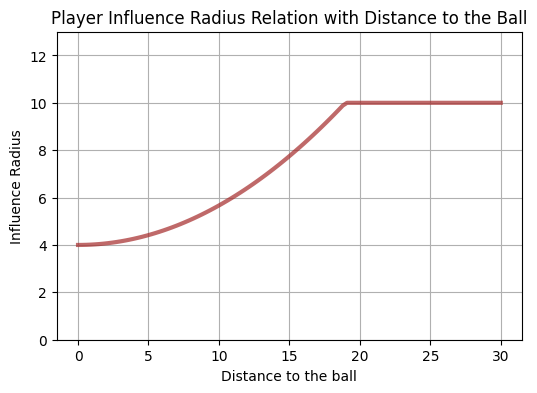

In [7]:
distances = np.linspace(0, 30, 100)  

player_position = np.array([0, 0])  
ball_positions = np.array([[d, 0] for d in distances])  

influence_radii = np.array([influence_radius(ball_pos, player_position) for ball_pos in ball_positions])

plt.figure(figsize=(6, 4))
plt.plot(distances, influence_radii, color='brown', linewidth=3, alpha=0.7)

plt.xlabel("Distance to the ball")
plt.ylabel("Influence Radius")
plt.title("Player Influence Radius Relation with Distance to the Ball")
plt.ylim(0, 13)
plt.grid(True)

plt.show()

A general 2D gaussian with mean vector $\mu$ and covariance matrix $COV$ can be defined as:

$$
f(p) =
\frac{1}{\sqrt{(2\pi)^2 \det \operatorname{COV}}}
\exp \left(
-\frac{1}{2} (p - \mu)^T \operatorname{COV}^{-1} (p - \mu)
\right)
$$

where: 
- $p = \begin{bmatrix} x \\ y \end{bmatrix}$ is the position vector.



The convariance matrix $COV$ ($\Sigma$) is a **symmetric positive semi-definite matrix**. This means it can be diagonalized using eigenvalue decomposition:

$$
\Sigma = VLV^{-1}
$$

where:
- $V$ is the orthogonal matrix containing the eigenvectors of $\Sigma$, representing the principal axes of the Gaussian distribution.
- $L$ is the diagonal matrix of **eigenvalues** $\lambda_1$, $\lambda_2$ of $\Sigma$, representing the variance along these axes.

Thus, the **eigenvalue decomposition** transforms the covariance matrix into its **principal components**, making it easier to work with multivariate analysis.

Then, the paper expresses $\Sigma$ in terms of a rotation matrix $R$ and a scaling matrix $S$.
- $R = V$
- $S = \sqrt{L} = \begin{bmatrix} \sqrt{\lambda_1} & 0 \\ 0 & \sqrt {\lambda_2} \end{bmatrix}$
    

Eventually, we can rewrite the covariance matrix as:

$$
\Sigma = RSSR^{-1}
$$

which means:
- $R$ rotates the data to align with the principal axes.
- $S$ scales the data according to the standard deviations.
- $SS$ reconstructs the variance along each principal component



Now, let's review the construction of rotation matrix and scaling matrix: 

**Rotation matrix**:

$$
R =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{bmatrix}
$$

It **rotates** the original coordinate system **counterclockwise** by $ \theta$ to align with the player's velocity direction. After rotation, $x$ direction is the moving direction, and $y$ direction becomes perpendicular to movement. 

**Scaling matrix**

$$
S_i(t) =
\begin{bmatrix}
\frac{R_i(t) + (R_i(t) Sratio(\bar{s}_i(t)))}{2} & 0 \\
0 & \frac{R_i(t) - (R_i(t) Sratio(\bar{s}_i(t)))}{2}
\end{bmatrix}
$$

where:

$$
Sratio(s) = \frac{s^2}{13^2}
$$

>Setting 13 $m/s$ as the maximum possible speed reachable, we calculate the ratio between players and the maximum speed. 

The scaling factor dynamically adjusts the player's influence shape. As the player **moves faster**, their influence area **stretches in the movement direction** (x-axis) while **contracting in the perpendicular direction** (y-axis).


In [8]:
def influence_function(player_position, locations, player_velocity, ball_position):
    # Eq. 16
    theta = np.arctan2(player_velocity[1], player_velocity[0] + 1e-7)

    R = np.array([[np.cos(theta), -np.sin(theta)], 
                  [np.sin(theta), np.cos(theta)]])
    R_inv = np.array([[np.cos(theta), np.sin(theta)], 
                      [-np.sin(theta), np.cos(theta)]])
    
    # Eq. 18
    speed_squared = player_velocity[0]**2 + player_velocity[1]**2
    
    srat = speed_squared / (13**2)
    
    # Eq. 19
    Ri = influence_radius(ball_position, player_position)
    
    S = np.array([[(1 + srat) * Ri * 0.5, 0], 
                  [0, (1 - srat) * Ri * 0.5]])
    
    # Eq. 20
    Cov = R @ S @ S @ R_inv

    # Eq. 21
    mu = player_position + 0.5 * player_velocity
    
    # Eq. 12
    gaussian_distribution = mvn(mu, Cov)
    
    # Eq. 13
    influence_degree = gaussian_distribution.pdf(locations) / np.max(gaussian_distribution.pdf(locations))
    
    return influence_degree

We can visualize and validate the construction of the **influence area function** as follows:

In [9]:
x = np.linspace(5, 25, 100)
y = np.linspace(5, 25, 100)
X, Y = np.meshgrid(x, y)
locations = np.dstack((X, Y))

In [10]:
def plot_influence(ax, X, Y, influence, player_position, ball_position, player_velocity, title):
    c = ax.contourf(X, Y, influence, cmap="coolwarm", levels=10, vmin=0, vmax=1)
    
    # Player (Blue dot)
    ax.scatter(*player_position, color="blue", edgecolors="black", s=100, marker="o")
    
    # Ball (Red dot)
    ax.scatter(*ball_position, color="white", edgecolors="black", s=50, marker="o")
    
    # Velocity Vector (Blue Arrow)
    scale_factor = 0.5 
    arrow_dx = player_velocity[0] * scale_factor
    arrow_dy = player_velocity[1] * scale_factor

    ax.arrow(player_position[0], player_position[1], arrow_dx, arrow_dy, color="blue", head_width=0.6, head_length=0.6, linewidth=2, alpha=0.8)
    
    ax.set_title(title)
    ax.set_xlabel("X distance in Meters")
    ax.set_ylabel("Y distance in Meters")
    ax.grid(True, linestyle="--", linewidth=0.5)
    return c

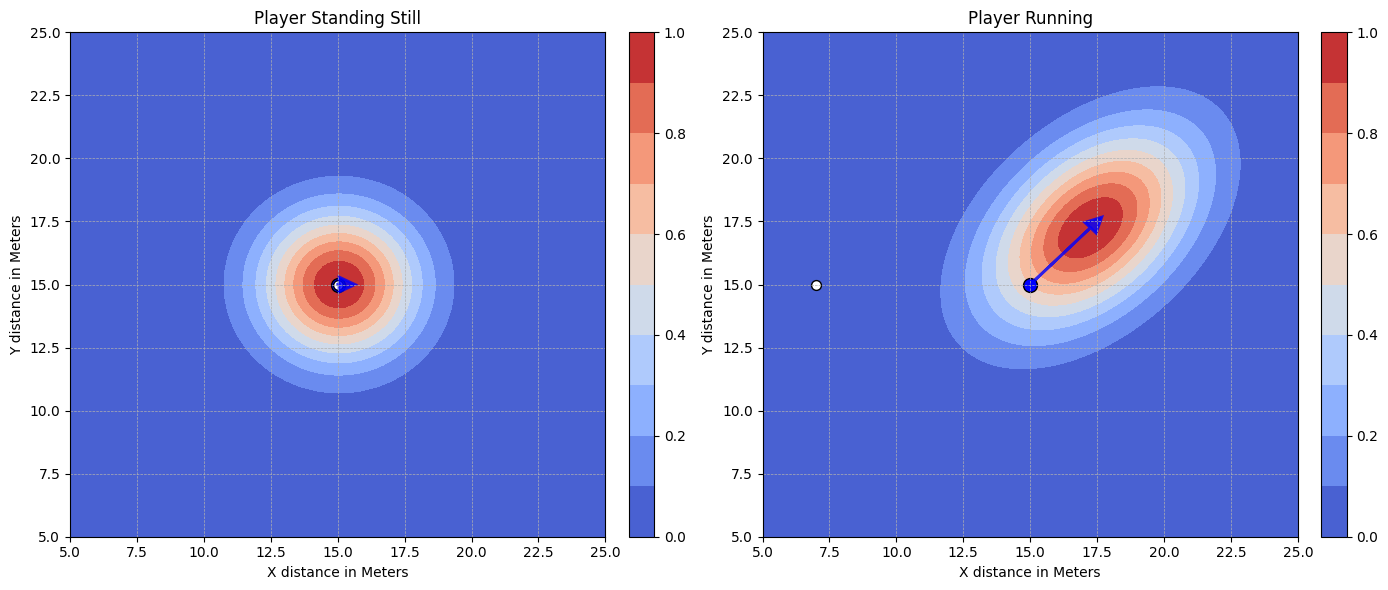

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Case 1: Player standing still 
player_position_1 = np.array([15, 15])
ball_position_1 = np.array([15, 15])
player_velocity_1 = np.array([0.1, 0])

influence_1 = influence_function(player_position_1, locations, player_velocity_1, ball_position_1)
c1 = plot_influence(ax1, X, Y, influence_1, player_position_1, ball_position_1, player_velocity_1, "Player Standing Still")

# Case 2: Player running at 45-degree angle
player_position_2 = np.array([15, 15])
ball_position_2 = np.array([7, 15])
player_velocity_2 = np.array([4.5, 4.5])

influence_2 = influence_function(player_position_2, locations, player_velocity_2, ball_position_2)
c2 = plot_influence(ax2, X, Y, influence_2, player_position_2, ball_position_2, player_velocity_2, "Player Running")

fig.colorbar(c1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(c2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In my implementation, at line 30 of the `influence_function`, I normalize the influence function as follows:

$$
I_i(p,t) = \frac{f_i(p,t)}{\text{max}f_i(p,t)}
$$ 

instead of using the equation provided in the paper:
$$
I_i(p,t) = \frac{f_i(p,t)}{f_i(p_i(t),t)}
$$

**Justification for this adaptation**:

The paper explicitly states that the influence function $I_i(p, t)$ is defined as:

>"a **normalization** of $f_i(p, t)$ by its value at the player's position... providing an initial model for obtaining a degree of influence within a $[0, 1]$ range for any given location on the field. 

However, this assumption does not hold when the player is in motion. Due to the velocity-dependent shift in the Gaussian distribution, the peak influence is no longer located exactly at the player's position $p_i(t)$ but rather slightly ahead in the direction of movement. As a result, dividing by $f_i(p_i(t),t)$ does not always produce a maximum value of 1.

To ensure that the influence function is properly normalized within [0,1], I modified the normalization approach by dividing by the **true maximum** of $f_i(p,t)$, ensuring that:

$$
\text{max}I_i(p,t) = 1
$$

## Modeling Team Pitch Control

The pitch control level at a location $p$ at time $t$ is given as:

$$
PC(p,t) = \sigma \left( \sum_{i} I(p,t) - \sum_{j} I(p,t) \right)
$$

where $I$ is the influence function, and $i$ and $j$ refers to the index of the players in each opposing team. 

In [12]:
def compute_team_influence(players, locations_m, ball_pos_m, sx, sy):
    infl_total = 0.0
    for _, p in players.iterrows():
        p_pos_m = np.array([p["x"] * sx, p["y"] * sy])
        p_vel_m = np.array([p["vx"] * sx, p["vy"] * sy])  
        infl_total += influence_function(p_pos_m, locations_m, p_vel_m, ball_pos_m)
    return infl_total

In [13]:
def draw_team(ax, df, color):
    ax.scatter(
        df["x"], df["y"],
        color=color,
        s=200,
        edgecolors="white",
        linewidth=2,
        zorder=10
    )

def draw_arrow(ax, x, y, vx, vy, color, zorder=7, 
               base_width=1, length_factor=0.4, offset=0.75,
               pitch_length=105, pitch_width=68):
    
    mag = np.hypot(vx, vy)
    if mag < 0.1: return 

    ux, uy = vx / mag, vy / mag
    ratio = pitch_width / pitch_length
    
    px, py = -uy * ratio, ux / ratio
    p_mag = np.hypot(px, py)
    px, py = (px / p_mag) * (base_width / 2), (py / p_mag) * (base_width / 2)

    cx, cy = x + ux * offset, y + uy * offset  
    
    points = [
        [cx + px, cy + py],                     
        [cx - px, cy - py],                     
        [cx + ux * (mag * length_factor),       
         cy + uy * (mag * length_factor)]
    ]

    ax.add_patch(Polygon(points, facecolor=color, edgecolor="white", 
                         linewidth=1.5, zorder=zorder))

In [ ]:
def plot_team_pitch_control(
    frame,
    df_home_players,
    df_away_players,
    df_ball,
    pitch_length=105,
    pitch_width=68,
    step=1.0,
    cmap_colors=None,
    player_colors=None,
    show_velocity=False
):
    pitch = Pitch(
        pitch_type="wyscout",
        linewidth=2,
        line_color="white"
    )

    # build grid in Wyscout space
    x_units = np.linspace(0, 100, int(100 / step) + 1)
    y_units = np.linspace(0, 100, int(100 / step) + 1)
    X_plot, Y_plot = np.meshgrid(x_units, y_units)
    sx, sy = pitch_length / 100.0, pitch_width / 100.0
    locations_m = np.column_stack([(X_plot * sx).ravel(), (Y_plot * sy).ravel()])

    # slice frame data
    home = df_home_players[df_home_players["frame"] == frame]
    away = df_away_players[df_away_players["frame"] == frame]
    ball_row = df_ball.loc[df_ball["frame"] == frame].iloc[0]
    ball_pos_m = np.array([ball_row["x"] * sx, ball_row["y"] * sy])

    # compute influence
    home_infl = compute_team_influence(home, locations_m, ball_pos_m, sx, sy)
    away_infl = compute_team_influence(away, locations_m, ball_pos_m, sx, sy)
    Z = (1 / (1 + np.exp(-(home_infl - away_infl)))).reshape(X_plot.shape)

    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    pitch.draw(ax=ax)

    ax.contourf(X_plot, Y_plot, Z, alpha=1, cmap=cmap_colors, levels=24, zorder=-1)

    draw_team(ax, away, player_colors["away"])
    draw_team(ax, home, player_colors["home"])

    if show_velocity:
        for team_df, color in [(home, player_colors["home"]), (away, player_colors["away"])]:
            for _, row in team_df.iterrows():
                draw_arrow(
                    ax, row['x'], row['y'], row['vx'], row['vy'], 
                    color=color, 
                    pitch_length=pitch_length, 
                    pitch_width=pitch_width
                )

    ax.scatter(
        ball_row["x"], 
        ball_row["y"], 
        s=100,              
        facecolor="white", 
        edgecolor="black", 
        linewidth=2.5, 
        zorder=30,          
        marker='o'
    )

    return fig, ax

Let's plot the team pitch control for 1 specific frame to validate the influence function we just implemented. 

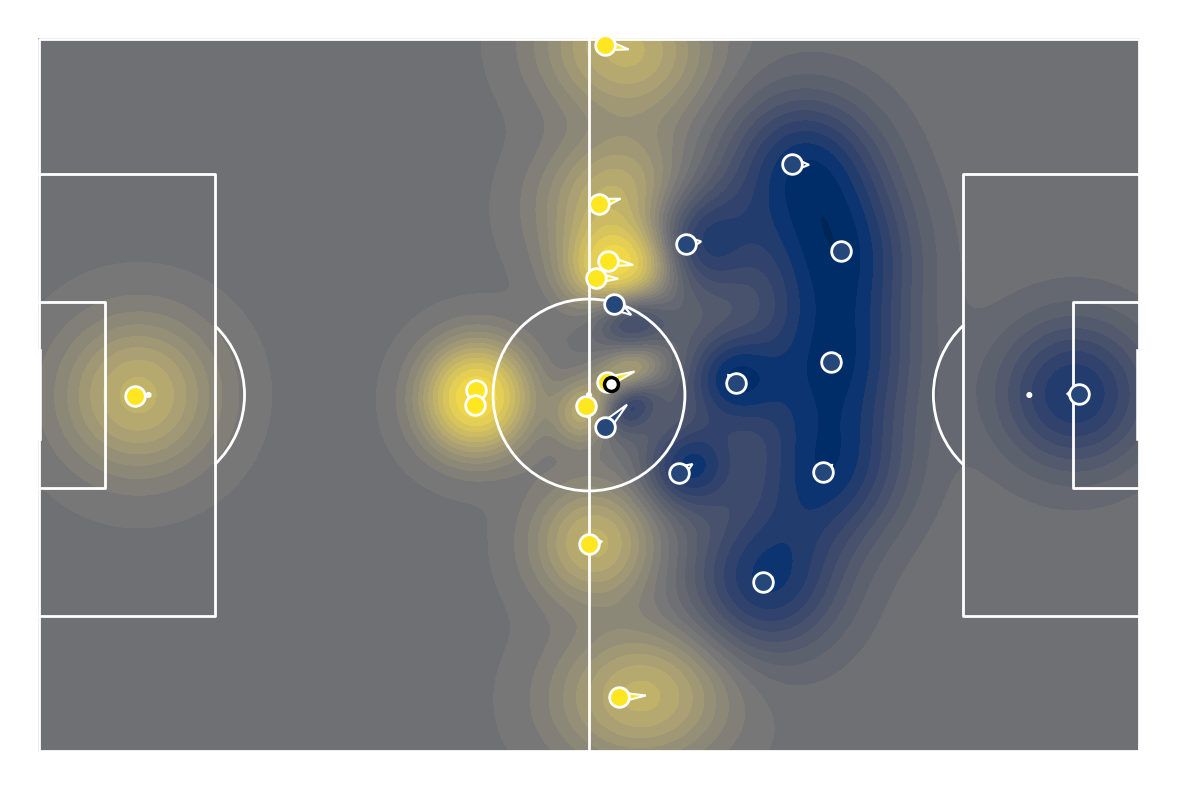

In [68]:
fig, ax = plot_team_pitch_control(
    frame=50,
    df_home_players=df_home_players,
    df_away_players=df_away_players,
    df_ball=df_ball,
    step=0.2,               
    cmap_colors="cividis",
    player_colors={"home": (0.995, 0.903, 0.125), "away": (0.150, 0.280, 0.480)},
    show_velocity=True
)

## Quantifying Pitch and Space Value

While identifying who controls a specific zone is a prerequisite for spatial analysis, it does not account for the tactical significance of that zone. To move from "control" to "value," we must quantify the danger associated with every coordinate on the pitch.

>... But exploring more deeply into the dynamics of soccer, and based on the opinion from F.C. Barcelona export analysts, it can be also argued that the value of space changes dynamically depending on multiple positional factors, such as the position of the ball and the players.

Departing from traditional models like `Expected Goals` (xG) or `Expected Threat` (xT) - which often rely on fixed spatial maps - this implementation utilizes the "Defense as a Sensor" hypothesis. We model the Surface of Value $(Q)$ as a dynamic expectation: **a deep neural network learns to predict the optimal defensive occupancy based solely on the ball's location**. By doing so, we define the value of space not by its proximity to the goal, but by the defensive priority a professional team assigns to it in real-time.

$$
V_{k,l}(t) = f_n(p_b(t), p_{k,l}; \theta)
$$

This equation represents the core of our **"Value of Space"** implementation. It defines the relative value of every position $(k,l)$ on the pitch at a specific time $t$, treating it as a dynamic function rather than a static map.
- $V_{k,l}​(t)$: The relative value assigned to the pitch coordinates (k,l) at time t.
- $p_b​(t)$: The location of the ball at time t. This is the primary input (independent variable) that dictates the current tactical context.
- $p_{k,l}$​: The specific spatial coordinates on the grid being evaluated.
- $fn​(…;θ)$: The mapping function represented by our Neural Network (where θ are the learned weights).

$$
D_{k,l}(t) = \sum_{d \in \text{Defenders}} I_d(p_b(t), p_{k,l}(t))
$$

The Density of Influence (Dk,l​) represents the total defensive "pressure" at a specific coordinate (k,l) at time t.
- $I_d$​: The individual influence function of defender d, which is conditioned on the ball's position $p_b​(t)$ and the player's own motion.
- The Summation: By summing these individual influences, we identify where the defensive block is most concentrated.
- Tactical Meaning: High values of D indicate areas that the defending team is actively "sensing" and prioritizing.

$$
\hat{V}_{k,l}(t) = 
\begin{cases} 
1 & \text{if } D_{k,l}(t) > 1 \\ 
D_{k,l}(t) & \text{otherwise} 
\end{cases}
$$

The Capped Target Surface $(\hat{V}_{k,l​})$ serves as the "Ground Truth" for our training labels $(y)$.
- **The Threshold**: Since multiple defenders can influence the same area, the raw sum $D_{k,l}$​ can exceed 1.0.
- **The "Bracket"** Logic: To treat the pitch value as a probability surface, the authors cap the value at 1. If the density is greater than 1, it is set to 1; otherwise, it retains its calculated value.

**Dual-Grid System for Spatial Analysis**

We implement a two-tier grid system to optimize the balance between tactical contextualization and kinetic precision. These grids are defined upfront to ensure that all subsequent calculations for Value, Influence, and Gain share a unified spatial reference.

`pv_grid`: Pitch Value Grid

Similar to *Expected Threat* (xT), the tactical surface operates on a zonal concept. In football, the strategic value of space—such as the "Half-space" or "Zone 14"—does not fluctuate significantly over a 10cm margin. By utilizing a coarser resolution (e.g., 21×15), we train the Neural Network to evaluate space through a structural lens. This avoids overcomplicating the model with micro-fluctuations and ensures the predicted values represent meaningful tactical zones rather than localized noise.


`pc_grid`: Pitch Control Grid

While tactics are zonal, physics is continuous. Seemingly negligible details in a player's velocity, orientation, and acceleration directly dictate the immediate "ownership" of space. To accurately model the generation and occupation of space, we use a high-resolution grid (e.g., 101×101). This precision allows the Influence Function to capture the smooth, Gaussian decay of a player's reach, ensuring that the boundaries of pitch control are mathematically rigorous and visually fluid.

In [16]:
pv_grid_size = (21, 15)

x_g = np.linspace(0, 100, pv_grid_size[0])
y_g = np.linspace(0, 100, pv_grid_size[1])
X_m, Y_m = np.meshgrid(x_g, y_g)
pv_grid = np.dstack((X_m, Y_m))

In [17]:
pc_grid_size = (101, 101)

x_grid = np.linspace(0, 100, pc_grid_size[0])
y_grid = np.linspace(0, 100, pc_grid_size[1])
X, Y = np.meshgrid(x_grid, y_grid)
pc_grid = np.stack([X.ravel(), Y.ravel()], axis=1)

In [18]:
def get_normalized_frame_data(frame_id, df_ball, df_home, df_away, grid_locations):
    """
    Calculates the Capped Target Surface (V_hat) for a frame.
    Standardizes direction: Attack is always L -> R (Goal at X=100).
    """
    row_ball = df_ball[df_ball['frame'] == frame_id].iloc[0]
    possession = row_ball['possession_team']
    
    if pd.isna(possession) or possession not in ['home', 'away']:
        return None

    # Identify defenders and set normalization
    if possession == 'home':
        # Home attacks L->R. Away is defending X=100.
        defenders = df_away[df_away['frame'] == frame_id]
        flip_x = False 
    else:
        # Away attacks R->L. Home is defending X=0. 
        # Flip to make Home defend X=100 and Away attack L->R.
        defenders = df_home[df_home['frame'] == frame_id]
        flip_x = True

    samples = []
    # Data Augmentation: Original and Vertical Flip
    for v_flip in [False, True]:
        bx, by = row_ball['x'], row_ball['y']
        
        if flip_x: bx = 100 - bx
        if v_flip: by = 100 - by
            
        norm_defs = defenders.copy()
        if flip_x:
            norm_defs['x'] = 100 - norm_defs['x']
            norm_defs['vx'] = -norm_defs['vx'] 
        if v_flip:
            norm_defs['y'] = 100 - norm_defs['y']
            norm_defs['vy'] = -norm_defs['vy']
            
        # Calculate D_{k,l} (Sum of defensive influences)
        norm_ball_pos = np.array([bx, by])
        D_kl = np.zeros((grid_locations.shape[0], grid_locations.shape[1]))
        
        for _, player in norm_defs.iterrows():
            p_pos = np.array([player['x'], player['y']])
            p_vel = np.array([player['vx'], player['vy']])
            # Add this defender's influence to the total density
            D_kl += influence_function(p_pos, grid_locations, p_vel, norm_ball_pos)
            
        # Calculate V_hat (Cap the density at 1.0)
        V_hat = np.clip(D_kl, 0, 1)
        
        # Spatial Smoothing
        V_hat_smooth = gaussian_filter(V_hat, sigma=2.0)
        
        X_feature = np.array([bx, by])
        samples.append((X_feature, V_hat_smooth.flatten()))
        
    return samples

In [19]:
X_train_list, y_train_list = [], []
unique_frames = df_ball['frame'].unique()[::25] # Sample every 0.5s-1s

for fid in unique_frames:
    samples = get_normalized_frame_data(fid, df_ball, df_home_players, df_away_players, pv_grid)
    if samples:
        for x_feat, y_surf in samples:
            X_train_list.append(x_feat)
            y_train_list.append(y_surf)

X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

print(f"Preprocessing Complete. Dataset shape: {X_train.shape}")

Preprocessing Complete. Dataset shape: (18020, 2)


$$
\theta^* = \arg \min_{\theta} \frac{1}{n} \sum_{e=1}^{n} \mathcal{L}(y_e, f(x_e, \theta))
$$

This equation represents the training process of the neural network. The goal is to find the optimal set of weights $(θ^*)$ that allow the model to generalize the defensive behavior.
- $n$: The total number of training examples.
- $x_e$​: The input features for example $e$, which in our case is the ball's normalized position $p_b​(t)$.
- $y_e$​: The ground truth target for example $e$, which is the Capped Target Surface $(\hat{V}_{k,l}​)$ calculated from the actual positions of the defenders.
- $f(x_e​,θ)$: The prediction made by the neural network—the Expected Value Surface $(Q)$.
- $L$: The Mean Square Error (MSE) loss function, which calculates the pixel-by-pixel difference between the actual defensive density and the predicted expectation.

In [20]:
class WideOpenSpacesNet(nn.Module):
    def __init__(self, input_dim=2, output_dim=315): # 21 * 15 = 315
        super(WideOpenSpacesNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), 
            nn.ReLU(),                 
            nn.Linear(128, output_dim),
            nn.Sigmoid()               
        )
        
    def forward(self, x):
        return self.model(x)

This is a classic Feed-forward Neural Network (Multi-Layer Perceptron) designed to compute a spatial "defensive focus" or "occupancy value" across a discretized football pitch. It functions as a non-linear mapping function $f: \mathbb{R}^2 \to \mathbb{R}^{315}$.

The input layer accepts a vector $v=[x,y]$, representing the instantaneous coordinates of the ball. In the context of this network, these two variables serve as the primary features from which all spatial dependencies are derived. 

The first transformation `nn.Linear()` is an affine mapping via a hidden layer of 128 neurons, which act as a high-dimensional feature extractor. This expansion allows the network to learn geometric primitives—such as distance, angle, and proximity to boundaries—that are not explicitly provided in the raw $[x,y]$ input.

The application of the Rectified Linear Unit, `nn.ReLU()`, introduces the necessary non-linearity. This allows the model to partition the pitch into complex, disjoint regions of influence, effectively enabling the network to "bend" its logic around specific spatial triggers.

The second linear layer, `nn.Linear(128,315)`, projects the learned features back onto a flattened representation of the pitch. By projecting 128 abstract features into 315 spatial points, the network performs an interpolation, predicting the defensive focus even in areas far removed from the current ball location.

The final layer employs a Sigmoid activation function `nn.Sigmoid()`. This squashes the raw logit outputs into a bounded range of [0,1], providing a normalized "Space Value" for every zone.

In [21]:
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Training on cpu...
Epoch [10/200], Loss: 0.012077
Epoch [20/200], Loss: 0.008499
Epoch [30/200], Loss: 0.008323
Epoch [40/200], Loss: 0.008201
Epoch [50/200], Loss: 0.008158
Epoch [60/200], Loss: 0.008105
Epoch [70/200], Loss: 0.008059
Epoch [80/200], Loss: 0.008008
Epoch [90/200], Loss: 0.008034
Epoch [100/200], Loss: 0.007994
Epoch [110/200], Loss: 0.007983
Epoch [120/200], Loss: 0.007987
Epoch [130/200], Loss: 0.007978
Epoch [140/200], Loss: 0.007943
Epoch [150/200], Loss: 0.007950
Epoch [160/200], Loss: 0.007935
Epoch [170/200], Loss: 0.007939
Epoch [180/200], Loss: 0.007925
Epoch [190/200], Loss: 0.007916
Epoch [200/200], Loss: 0.007932


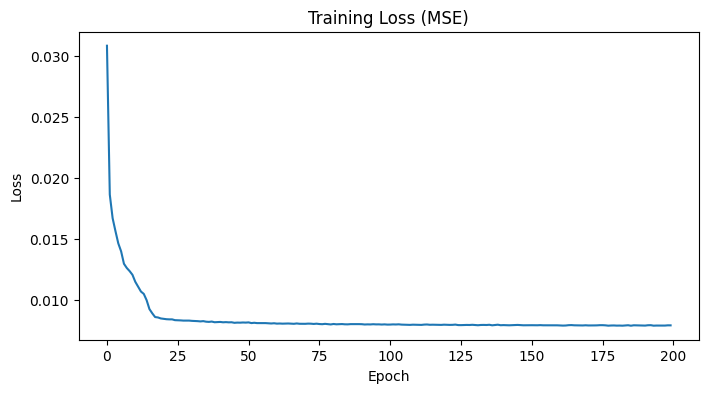

In [22]:
model = WideOpenSpacesNet(input_dim=2, output_dim=315).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Paper uses Adam

epochs = 200
loss_history = []

model.train()
print(f"Training on {device}...")

for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass: f(x, theta)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass: arg min theta
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [71]:
def plot_test_results(model, X_test, y_test, num_samples=3):
    model.eval()
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    grid_shape = (15, 21) 
    
    pitch = Pitch(pitch_type='wyscout', line_color='#7c7c7c', goal_type='box')
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 5.5 * num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            x_input = torch.tensor(X_test[idx], dtype=torch.float32).unsqueeze(0).to(device)
            pred = model(x_input).cpu().numpy().reshape(grid_shape)
            actual = y_test[idx].reshape(grid_shape)
            ball_x, ball_y = X_test[idx][0], X_test[idx][1]
            
            for j, (data, title) in enumerate([
                (actual, fr"Sample {idx}: Observed Density ($\hat{{V}}$)"),
                (pred, fr"Sample {idx}: Expected Value Surface ($Q$)")
            ]):
                ax = axes[i, j]
                pitch.draw(ax=ax)
                
                im = ax.imshow(data, extent=[0, 100, 0, 100], origin='lower', 
                               cmap='Reds', vmin=0, vmax=1, alpha=0.6, 
                               aspect=0.65) 
                
                pitch.scatter(ball_x, ball_y, color='black', s=100, 
                              edgecolors='white', linewidth=1.5, ax=ax, zorder=3)
                ax.set_title(title, fontsize=14, pad=10)

                fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)

    plt.tight_layout() 
    plt.show()

Now, we have a mdel that can predict pitch value in a $[0,1]$ range for given ball locations.

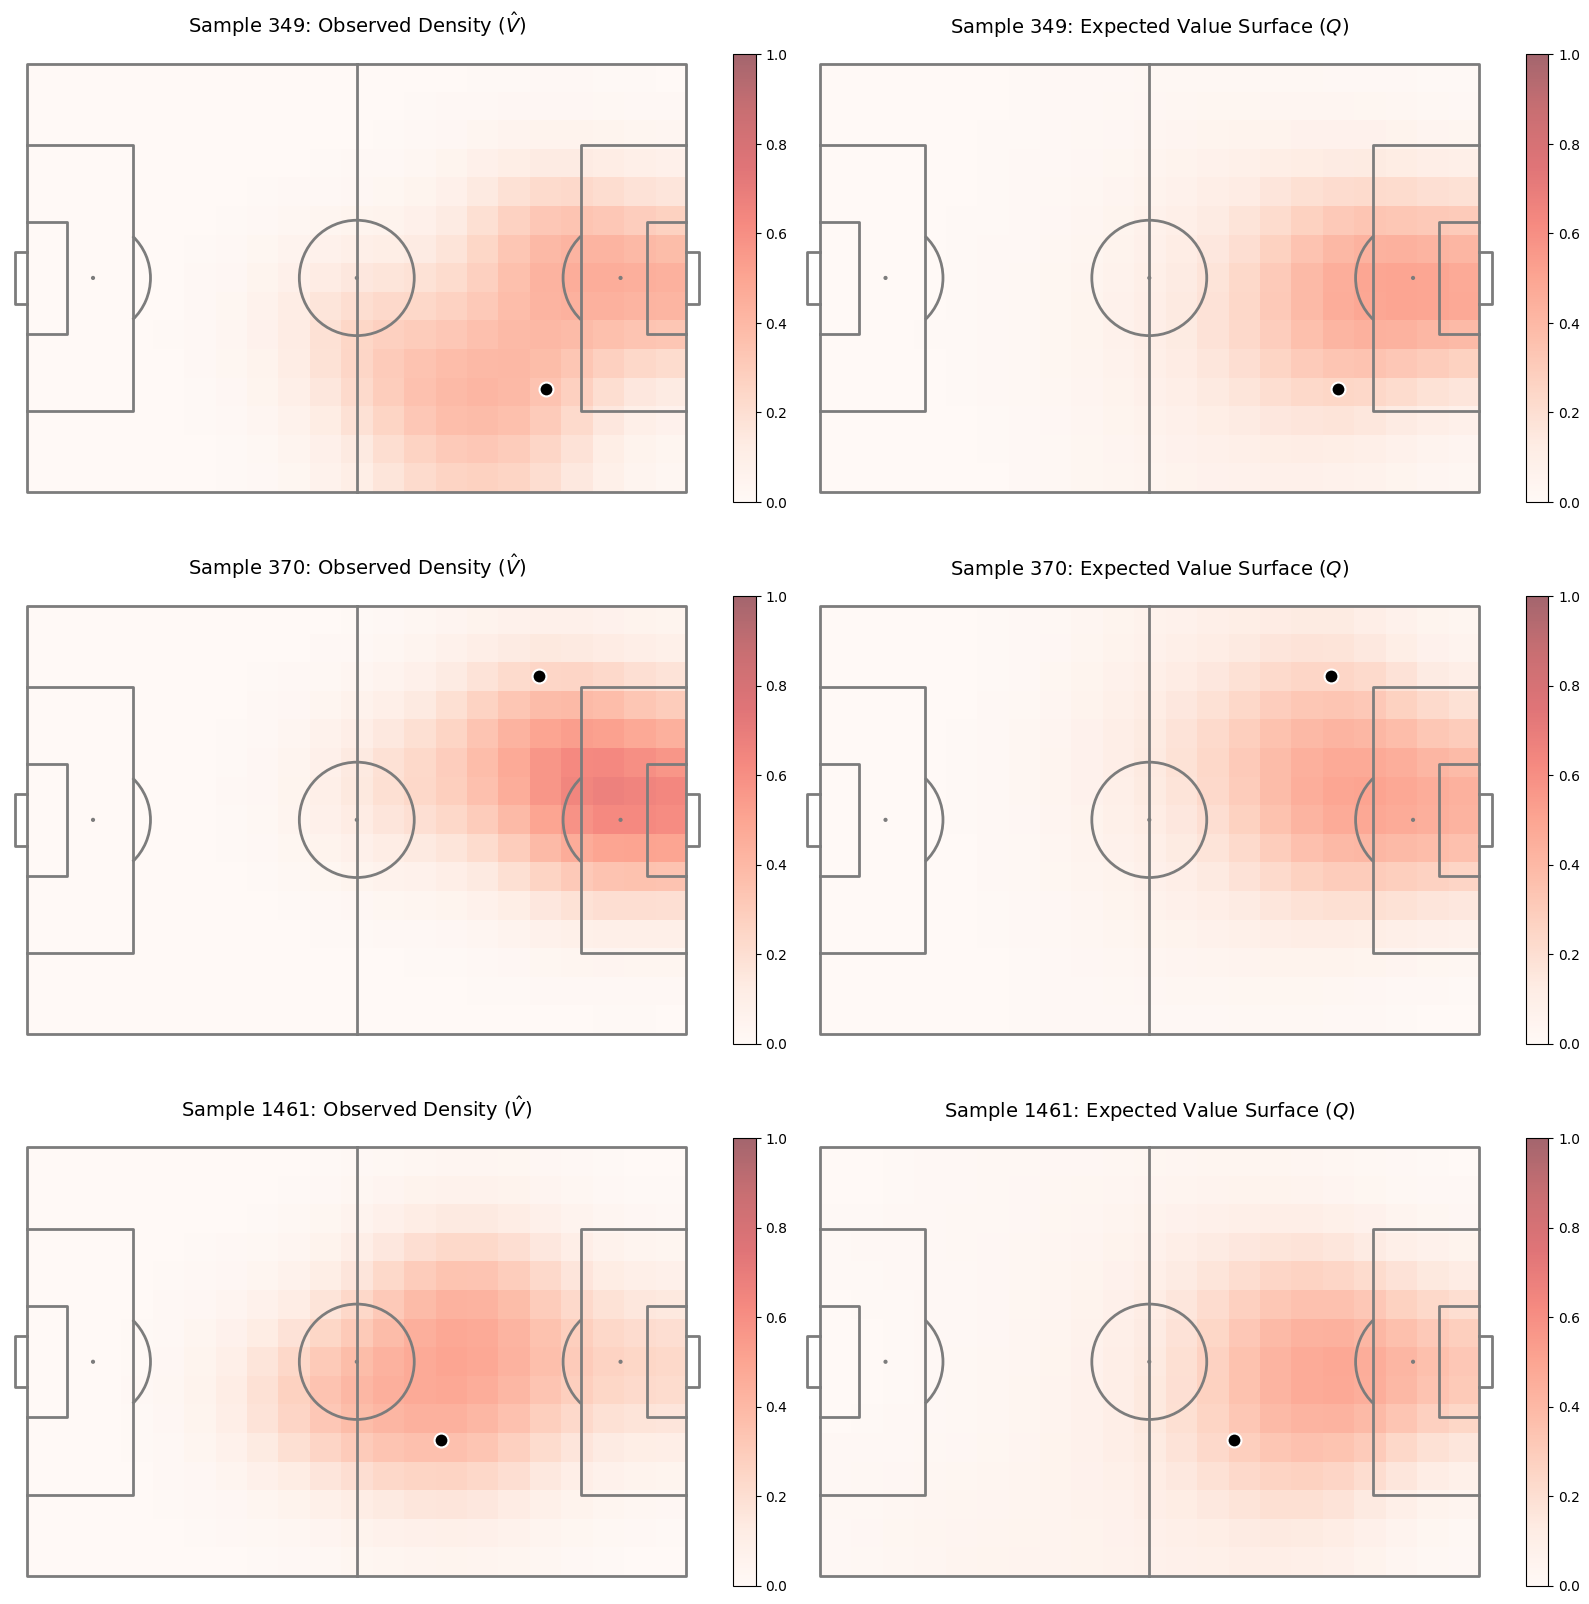

In [73]:
plot_test_results(model, X_train, y_train)

## Occupation and Generation of Space

>The quality of positioning of a given player is related with having the best possible control of the space, and doing so for spaces with higher value. 

We use $Q_i(t)$ to represent such **quality of owned space**, and it is expressed as:

$$
Q_i(t) = PC_i(t)V(t)
$$

where the $PC_i(t)$ value is obtained from the team pitch control model, and $V(t)$ is obtained from the ball-relative field value model we just trained above. 

In [25]:
def plot_pc_vs_q(frame_id, model, df_home, df_away, df_ball, device):
    model.eval()
    
    pitch = Pitch(pitch_type='wyscout', line_color='#7c7c7c', goal_type='box')
    _, axes = plt.subplots(1, 2, figsize=(20, 8))

    ball_row = df_ball[df_ball['frame'] == frame_id].iloc[0]
    bx, by = ball_row['x'], ball_row['y']
    
    ball_input = torch.tensor([[bx, by]], dtype=torch.float32).to(device)
    with torch.no_grad():
        V_raw = model(ball_input).cpu().numpy().reshape(15, 21)

    x_paper = np.linspace(0, 100, 21)
    y_paper = np.linspace(0, 100, 15)
    interp_func = RegularGridInterpolator((y_paper, x_paper), V_raw, bounds_error=False, fill_value=0)
    V_interp = interp_func(np.array([Y.ravel(), X.ravel()]).T).reshape(101, 101)

    home_frame = df_home[df_home['frame'] == frame_id]
    away_frame = df_away[df_away['frame'] == frame_id]

    h_infl = compute_team_influence(home_frame, pc_grid, np.array([bx, by]), 1.0, 1.0)
    a_infl = compute_team_influence(away_frame, pc_grid, np.array([bx, by]), 1.0, 1.0)
    PC = (1 / (1 + np.exp(-(h_infl - a_infl)))).reshape(101, 101)

    Q = PC * V_interp

    surfaces = [PC, Q]
    titles = ["Pitch Control ($PC$)", r"Space Quality ($Q = PC \cdot \hat{V}$)"]
    cmaps = ['bwr', 'Reds']

    for i, ax in enumerate(axes):
        pitch.draw(ax=ax)
        
        im = ax.imshow(surfaces[i], extent=[0, 100, 0, 100], origin='lower', 
                        cmap=cmaps[i], alpha=0.7, aspect='auto')
        
        pitch.scatter(bx, by, color='white', s=60, edgecolors='black', linewidth=1.5, ax=ax, zorder=4)
        
        pitch.scatter(home_frame.x, home_frame.y, color='red', edgecolors='black', s=80, ax=ax)
        pitch.scatter(away_frame.x, away_frame.y, color='blue', edgecolors='black', s=80, ax=ax)
        
        ax.set_title(titles[i], fontsize=16, pad=10)

    plt.tight_layout()
    plt.show()

In Matplotlib, both `contourf` and `imshow` are used to visualize 2D data. `imshow` is like a photograph (made of pixels), while `contourf` is like a topographic map (made of smooth, colored regions). 

**Pitch Control** is a probabilistic model. Control doesn't "snap" from 100% to 0% at a specific pixel. We used `contourf` to draw smooth boundaries that better represent the physical reality of a player's "influence" spreading across the pitch.

**Space Value** is calculated on a discrete grid. Space-value-related surfaces are about magnitude not just ownership. Therefore, we will use `imshow` functions from now on to emphasize the "quality" of the space in the following visualizations.

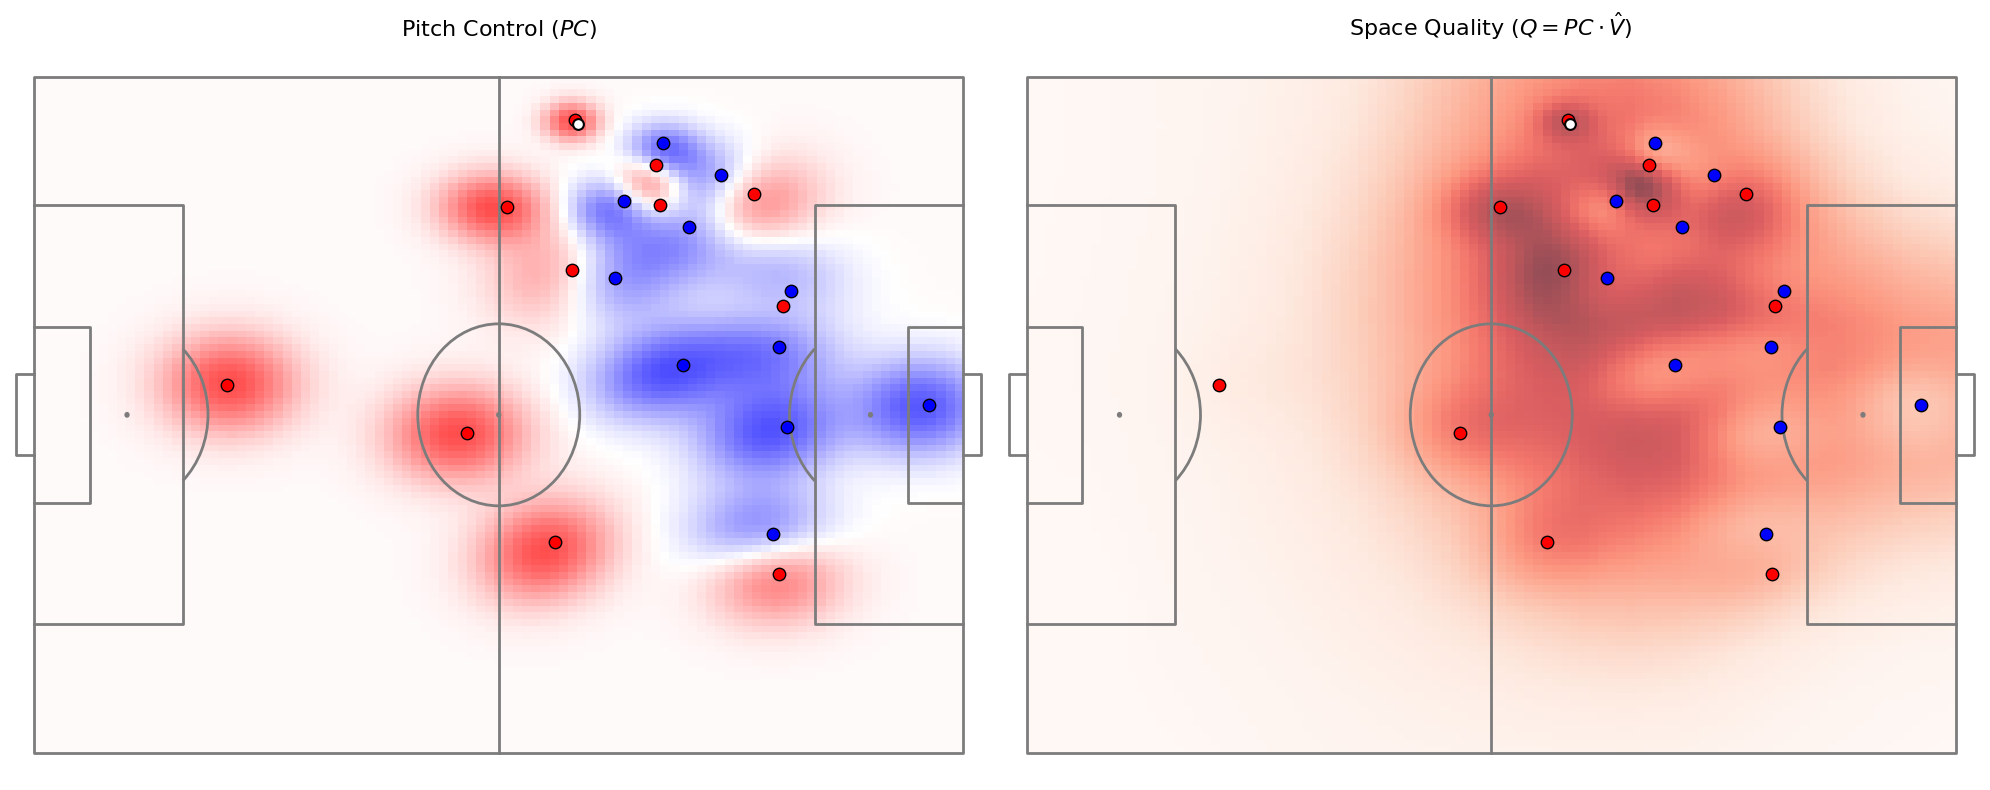

In [26]:
plot_pc_vs_q(500, model, df_home_players, df_away_players, df_ball, device)

### Space Occupation Gain

The metric $G_i​(t)$ represents the average rate of change in the quality of space occupied by player $i$ over a specific time window $w$.

$$
G_i(t) = \frac{\sum_{t'=t+1}^{t+w+1} Q_i(t')}{w}
$$

The equation can be interpreted as follows:
- **Cumulative Difference**: We calculate the change in Space Quality (Q) between consecutive frames throughout the window. Summing these differences effectively measures the net improvement (or decline) in the player's spatial footprint from the start to the end of the interval.
- **Temporal Averaging**: By dividing the total change by the window size w, we derive the mean gain per frame. This normalization filters out "noise" from incidental movements, ensuring that only persistent, intentional actions are captured.
- **Tactical Interpretation**: A positive $G_i​(t)$ indicates that, on average, the player is successfully moving into space that is either tactically more valuable (better $V$) or physically easier to control (higher $PC$), or a combination of both.

In practice, we apply a threshold to this value to identify **"Space Occupation Gain"** events:

$$
SOG_i(t) = \max(0, G_i(t) - \epsilon)
$$

$$
SOL_i(t) = \max(0, -(G_i(t) + \epsilon))
$$

For the vectorized function to work, it needs a specific 3D Tensor structure: $(Y, X, 2)$.

In [27]:
x_grid = np.linspace(0, 100, 101)
y_grid = np.linspace(0, 100, 101)
X, Y = np.meshgrid(x_grid, y_grid)
pc_grid_3d = np.stack([X, Y], axis=-1)

The cumulative gain over a time window $w$ can be expressed as the sum of incremental changes. Mathematically, this is a **Telescoping Sum**, where the intermediate terms cancel out, leaving only the difference between the final and initial states:

$$\sum_{i=t+1}^{t+w+1} (Q_{i} - Q_{i-1}) = (Q_{t+1} - Q_{t}) + (Q_{t+2} - Q_{t+1}) + \dots + (Q_{t+w+1} - Q_{t+w})$$

$$\sum_{i=t+1}^{t+w+1} (Q_{i} - Q_{i-1}) = Q_{t+w+1} - Q_{t}$$

To calculate the **Average Space Occupation Gain ($G_i$)** as defined in the literature, we take this net difference and divide by the window size $w$:

$$G_i(t) = \frac{Q_{t+w+1} - Q_{t}}{w}$$

Here we defined an upgraded influence function, moving from scalar/object-based logic to array-based computing. 

In [84]:
def influence_function_vectorized(player_positions, player_velocities, ball_position, grid_points):
    num_players = player_positions.shape[0]
    Y, X, _ = grid_points.shape
    
    thetas = np.arctan2(player_velocities[:, 1], player_velocities[:, 0] + 1e-7)
    speeds_sq = np.sum(player_velocities**2, axis=1)
    srat = speeds_sq / (13**2)
    Ri = influence_radius(ball_position, player_positions)
    
    mus = player_positions + 0.5 * player_velocities
    
    cos_t, sin_t = np.cos(thetas), np.sin(thetas)
    R = np.zeros((num_players, 2, 2))
    R[:, 0, 0], R[:, 0, 1] = cos_t, -sin_t
    R[:, 1, 0], R[:, 1, 1] = sin_t, cos_t
    
    S = np.zeros((num_players, 2, 2))
    S[:, 0, 0] = (1 + srat) * Ri * 0.5
    S[:, 1, 1] = (1 - srat) * Ri * 0.5
    
    Cov = R @ S @ S @ np.transpose(R, (0, 2, 1))
    
    inv_Cov = np.linalg.inv(Cov)
    
    diff = grid_points[None, :, :, :] - mus[:, None, None, :]
    
    intermediate = np.einsum('nyxj,njk->nyxk', diff, inv_Cov)
    exponent = np.einsum('nyxk,nyxk->nyx', intermediate, diff)
    
    influence_degree = np.exp(-0.5 * exponent)
    
    return influence_degree

In [86]:
def compute_team_pitch_control(home_df, away_df, ball_pos, grid_points_3d, sx=1.05, sy=0.68):
    scale = np.array([sx, sy])
    b_pos_m = np.array(ball_pos) * scale
    
    if not home_df.empty:
        h_pos = home_df[['x', 'y']].values * scale
        h_vel = home_df[['vx', 'vy']].values * scale

        h_player_inf = influence_function_vectorized(h_pos, h_vel, b_pos_m, grid_points_3d)
        h_total_influence = np.sum(h_player_inf, axis=0)
    else:
        h_total_influence = np.zeros(grid_points_3d.shape[:2])

    if not away_df.empty:
        a_pos = away_df[['x', 'y']].values * scale
        a_vel = away_df[['vx', 'vy']].values * scale
        
        a_player_inf = influence_function_vectorized(a_pos, a_vel, b_pos_m, grid_points_3d)
        a_total_influence = np.sum(a_player_inf, axis=0)
    else:
        a_total_influence = np.zeros(grid_points_3d.shape[:2])

    pitch_control = 1 / (1 + np.exp(-(h_total_influence - a_total_influence)))
    
    return pitch_control.reshape(grid_points_3d.shape[0], grid_points_3d.shape[1])

In [87]:
def calculate_individual_G(player_id, team_df, opponent_df, t, w, model, df_ball, device, pc_grid):
    sx, sy = 1.05, 0.68
    boundary_frames = [t, t + w + 1]
    
    ball_data = df_ball[df_ball['frame'].isin(boundary_frames)].set_index('frame')
    player_data = team_df[(team_df['frame'].isin(boundary_frames)) & 
                          (team_df['player'] == player_id)].set_index('frame')
    
    if len(ball_data) < 2 or ball_data[['x', 'y']].isna().any().any():
        raise ValueError(f"Ball data missing at boundaries: {t} or {t+w+1}")
    if len(player_data) < 2:
        return 0.0 

    # Batch inference (2 frames)
    ball_inputs = torch.tensor(ball_data[['x', 'y']].values, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        V_raw = model(ball_inputs).reshape(2, 1, 15, 21)
        V_batch = F.interpolate(V_raw, size=(pc_grid.shape[0], pc_grid.shape[1]), 
                                mode='bilinear', align_corners=True).squeeze(1).cpu().numpy()

    # Pitch control (2 frames)
    pc_list = [
        compute_team_pitch_control(
            team_df[team_df['frame'] == f], 
            opponent_df[opponent_df['frame'] == f], 
            ball_data.loc[f, ['x', 'y']].values, 
            pc_grid, 
            sx=sx, sy=sy
        ) for f in boundary_frames
    ]
    
    pc_batch = np.array(pc_list) # Shape: (2, 101, 101)

    p_x_idx = np.clip(player_data['x'].values.astype(int), 0, 100)
    p_y_idx = np.clip(player_data['y'].values.astype(int), 0, 100)

    pc_at_player = pc_batch[[0, 1], p_y_idx, p_x_idx]
    v_at_player = V_batch[[0, 1], p_y_idx, p_x_idx]

    q_start = pc_at_player[0] * v_at_player[0]
    q_end = pc_at_player[1] * v_at_player[1]
    
    return (q_end - q_start) / w

The function can be validated using a single time window:

In [88]:
test_player_id = 2401  
start_frame = 2050     
window = 50            

gi_val = calculate_individual_G(
    player_id=test_player_id, 
    team_df=df_home_players, 
    opponent_df=df_away_players, 
    t=start_frame, 
    w=window, 
    model=model, 
    df_ball=df_ball, 
    device=device, 
    pc_grid=pc_grid_3d
)

print(f"Vectorized G_i(t): {gi_val:.6f}")

Vectorized G_i(t): -0.000522


In [135]:
def plot_surface_quality_analysis(player_id, t, w, team_df, opponent_df, df_ball, model, pc_grid, device):
    gi_t = calculate_individual_G(player_id, team_df, opponent_df, t, w, model, df_ball, device, pc_grid)

    frames = [t, t + w + 1]
    ball_data = df_ball[df_ball['frame'].isin(frames)].set_index('frame')
    p_data = team_df[(team_df['frame'].isin(frames)) & (team_df['player'] == player_id)].set_index('frame')

    ball_inputs = torch.tensor(ball_data[['x', 'y']].values, dtype=torch.float32).to(device)
    with torch.no_grad():
        V_raw = model(ball_inputs).reshape(2, 1, 15, 21)
        V_batch = F.interpolate(V_raw, size=pc_grid.shape[:2], mode='bilinear', align_corners=True).squeeze(1).cpu().numpy()

    pitch = Pitch(pitch_type='wyscout', line_color='#7c7c7c', goal_type='box', pitch_color='#1a1a1a')
    fig, axes = plt.subplots(1, 2, figsize=(22, 10), facecolor='#1a1a1a')
    X, Y = np.meshgrid(np.linspace(0, 100, pc_grid.shape[1]), np.linspace(0, 100, pc_grid.shape[0]))

    for i, f in enumerate(frames):
        ax = axes[i]
        pitch.draw(ax=ax)

        frame_home = team_df[team_df['frame'] == f]
        frame_away = opponent_df[opponent_df['frame'] == f]
        frame_ball = ball_data.loc[f, ['x', 'y']].values
        
        pc_surf = compute_team_pitch_control(
            frame_home, 
            frame_away, 
            frame_ball, 
            pc_grid, 
            sx=1.05, 
            sy=0.68
        )
        
        q_surf = pc_surf * V_batch[i]

        extent = [0, 100, 0, 100]
        img = ax.imshow(q_surf, extent=extent, origin='lower', 
                        cmap='magma', alpha=0.8, zorder=0, aspect=0.64)

        pitch.scatter(opponent_df[opponent_df['frame']==f].x, opponent_df[opponent_df['frame']==f].y, 
                      s=70, c='#00E5FF', edgecolors='white', ax=ax, alpha=0.6, zorder=2)
        
        pitch.scatter(team_df[team_df['frame']==f].x, team_df[team_df['frame']==f].y, 
                      s=70, c='#FF4B4B', edgecolors='white', ax=ax, alpha=0.6, zorder=2)
        
        target = p_data.loc[f]
        pitch.scatter(target.x, target.y, s=600, facecolors='none', edgecolors='lime', 
                      linewidth=3, marker='o', ax=ax, zorder=10) 
        
        pitch.scatter(ball_data.loc[f].x, ball_data.loc[f].y, s=50, 
                      c='white', edgecolors='black', ax=ax, zorder=11)
        
        ax.set_title(f"Surface Quality Q | Player ID: {player_id}\nFrame: {f}", 
                     color='white', fontsize=16, pad=15)

    plt.suptitle(f"Space Occupation Analysis\n$G_i(t) = {gi_t:.6f}$", 
                 color='white', fontsize=24, y=0.98)
    
    plt.subplots_adjust(left=0.05, right=0.9, wspace=0.1)
    plt.tight_layout()
    
    return fig, axes

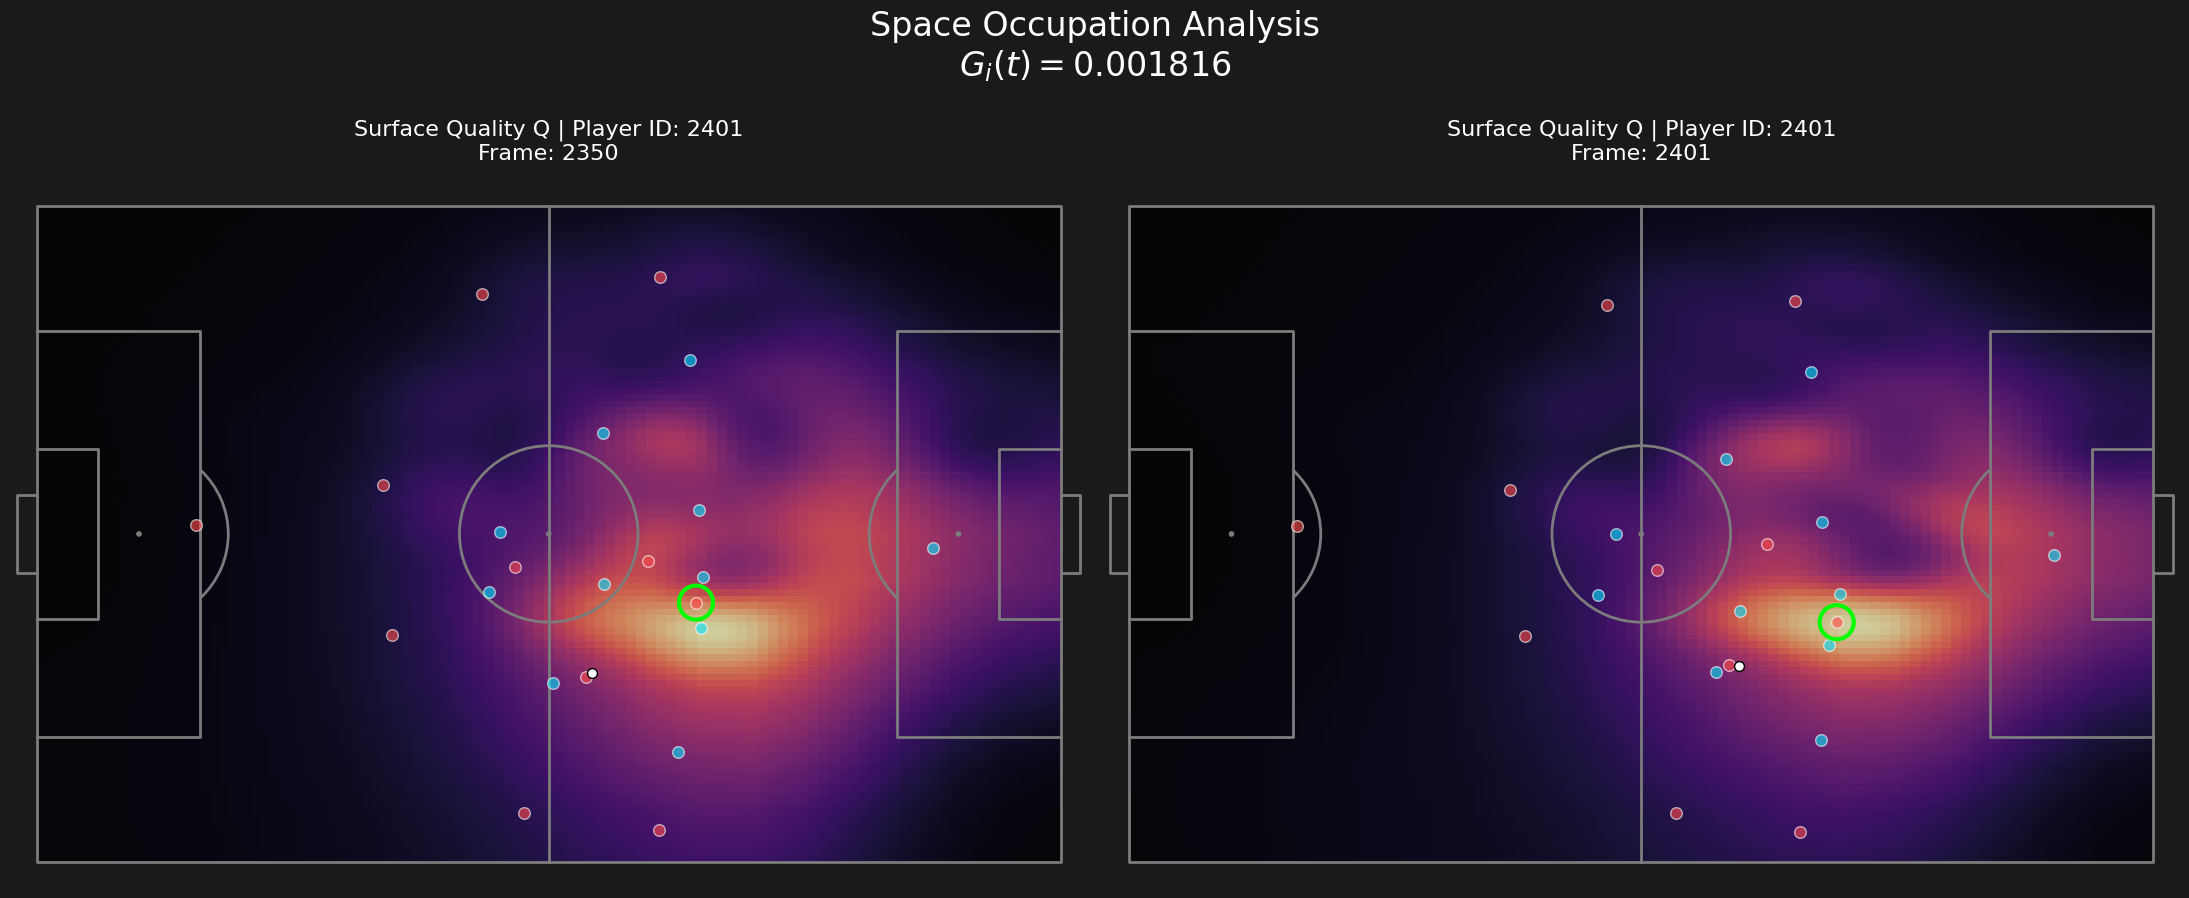

In [136]:
fig, axes = plot_surface_quality_analysis(2401, 2350, 50, df_home_players, df_away_players, df_ball, model, pc_grid_3d, device)

For the ease of future data preprocessing, we define a function that takes the ball data and the player's team, then returns the validated list of start frames.

In [163]:
def get_valid_window_starts(df_ball, p_team, w=50):
    # Find all frames where team has possession and ball is tracked
    valid_possession_mask = (
        (df_ball['possession_team'] == p_team) & 
        (df_ball['x'].notna()) & 
        (df_ball['y'].notna())
    )
    all_valid_frames = df_ball[valid_possession_mask]['frame'].values
    
    if len(all_valid_frames) == 0:
        return np.array([])

    # Potential starts (must have room for the look-ahead window)
    max_allowable_frame = all_valid_frames.max() - (w + 1)
    potential_starts = all_valid_frames[all_valid_frames <= max_allowable_frame]
    
    # Sub-sample by window size
    window_starts = potential_starts[::w]

    # Final boundary check: Ball must exist at the end of the window
    # Using a set for O(1) lookup speed
    valid_ball_frames = set(df_ball[df_ball['x'].notna()]['frame'])
    window_starts = [t for t in window_starts if (t + w + 1) in valid_ball_frames]
    
    return np.array(window_starts)

In [ ]:
def calculate_player_sog(player_id, team_df, opponent_df, df_ball, model, pc_grid, device, w=50, fps=50, epsilon=0.001, jog_limit=1.5):
    sx, sy = 1.05, 0.68

    p_team = "home" if player_id in team_df['player'].unique() else "away"
    player_frames = team_df[team_df['player'] == player_id]['frame']
    p_start, p_end = player_frames.min(), player_frames.max()
    
    window_starts = get_valid_window_starts(df_ball, p_team, w)
    
    if len(window_starts) == 0:
        return None
    
    sog_data = {
        'player_id': player_id,
        'team': p_team,
        'tenure': (p_start, p_end),
        'metadata': {'epsilon': epsilon, 'jog_limit': jog_limit, 'fps': fps},
        'windows': []
    }

    print(f"Analyzing Player {player_id}: {len(window_starts)} windows...")
    
    # Pre-index player data for faster coordinate lookup
    player_indexed = team_df[team_df['player'] == player_id].set_index('frame')
    
    for t in window_starts:
        if t not in player_indexed.index:
            continue
            
        try:
            # 1: Space Gain Calculation
            gi = calculate_individual_G(player_id, team_df, opponent_df, t, w, model, df_ball, device, pc_grid)
            
            # 2: Capture Player State (Velocity and Position)
            p_row = player_indexed.loc[t]
            
            # Position for heatmap plotting
            pos_x, pos_y = p_row['x'], p_row['y']
            
            # Velocity calculation
            speed_ms = np.sqrt((p_row['vx'] * sx)**2 + (p_row['vy'] * sy)**2)
            is_active = speed_ms >= jog_limit
            
            # 3: Categorization
            if gi > epsilon:
                impact_cat = 'gain'
            elif gi < -epsilon:
                impact_cat = 'loss'
            else:
                impact_cat = 'noise'
            
            # 4. Append with spatial data
            sog_data['windows'].append({
                'frame': t,
                'x': pos_x,
                'y': pos_y,
                'gi': gi,
                'speed': speed_ms,
                'is_active': is_active,      
                'category': impact_cat,     
                'is_impact': impact_cat != 'noise' 
            })
        except:
            continue
                
    return sog_data

In [181]:
player_sog = calculate_player_sog(2401, df_home_players, df_away_players, df_ball, model, pc_grid_3d, device)

Analyzing Player 2401: 2411 windows...


In [166]:
def plot_player_sog_momentum(momentum_data):
    if not momentum_data or not momentum_data['windows']:
        return print("No data available.")

    meta = momentum_data['metadata']
    p_start, p_end = momentum_data['tenure']
    
    plt.figure(figsize=(24, 8), facecolor='#1a1a1a')
    ax = plt.gca(); ax.set_facecolor('#1a1a1a')

    cat_colors = {'gain': '#00FF00', 'loss': '#FF0000', 'noise': '#808080'}
    
    all_times = [win['frame'] / (meta['fps'] * 60.0) for win in momentum_data['windows']]
    all_gi = [win['gi'] for win in momentum_data['windows']]
    plt.step(all_times, all_gi, where='post', color='white', linewidth=0.6, alpha=0.1)
    
    plt.axhline(meta['epsilon'], color='lime', linestyle=':', linewidth=1, alpha=0.3)
    plt.axhline(-meta['epsilon'], color='red', linestyle=':', linewidth=1, alpha=0.3)
    plt.axhline(0, color='white', linestyle='-', linewidth=0.8, alpha=0.2)

    for win in momentum_data['windows']:
        t_min = win['frame'] / (meta['fps'] * 60.0)
        
        plt.scatter(
            t_min, win['gi'], 
            color=cat_colors[win['category']],
            alpha=1.0 if win['is_impact'] else 0.15,
            marker='o' if win['is_active'] else 'x',
            s=80 if win['is_active'] else 60,
            zorder=3,
            edgecolors='white' if win['is_impact'] else 'none',
            linewidth=0.5
        )

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f"Active (>{meta['jog_limit']}m/s)", markerfacecolor='gray', lw=0),
        Line2D([0], [0], marker='x', color='w', label=f"Passive (<{meta['jog_limit']}m/s)", markerfacecolor='gray', lw=0),
        Line2D([0], [0], color='#00FF00', label=f"Gain > {meta['epsilon']}"),
        Line2D([0], [0], color='#FF0000', label=f"Loss < -{meta['epsilon']}")
    ]
    ax.legend(handles=legend_elements, loc='upper right', facecolor='#222', labelcolor='white')

    plt.title(f"Space Occupation Analysis | Player {momentum_data['player_id']}", color='white', fontsize=20)
    plt.xlim(p_start / (meta['fps'] * 60.0), p_end / (meta['fps'] * 60.0))
    plt.xlabel("Minutes", color='white'); plt.ylabel("Gain $G_i$", color='white')
    plt.tick_params(colors='white'); plt.tight_layout(); plt.show()

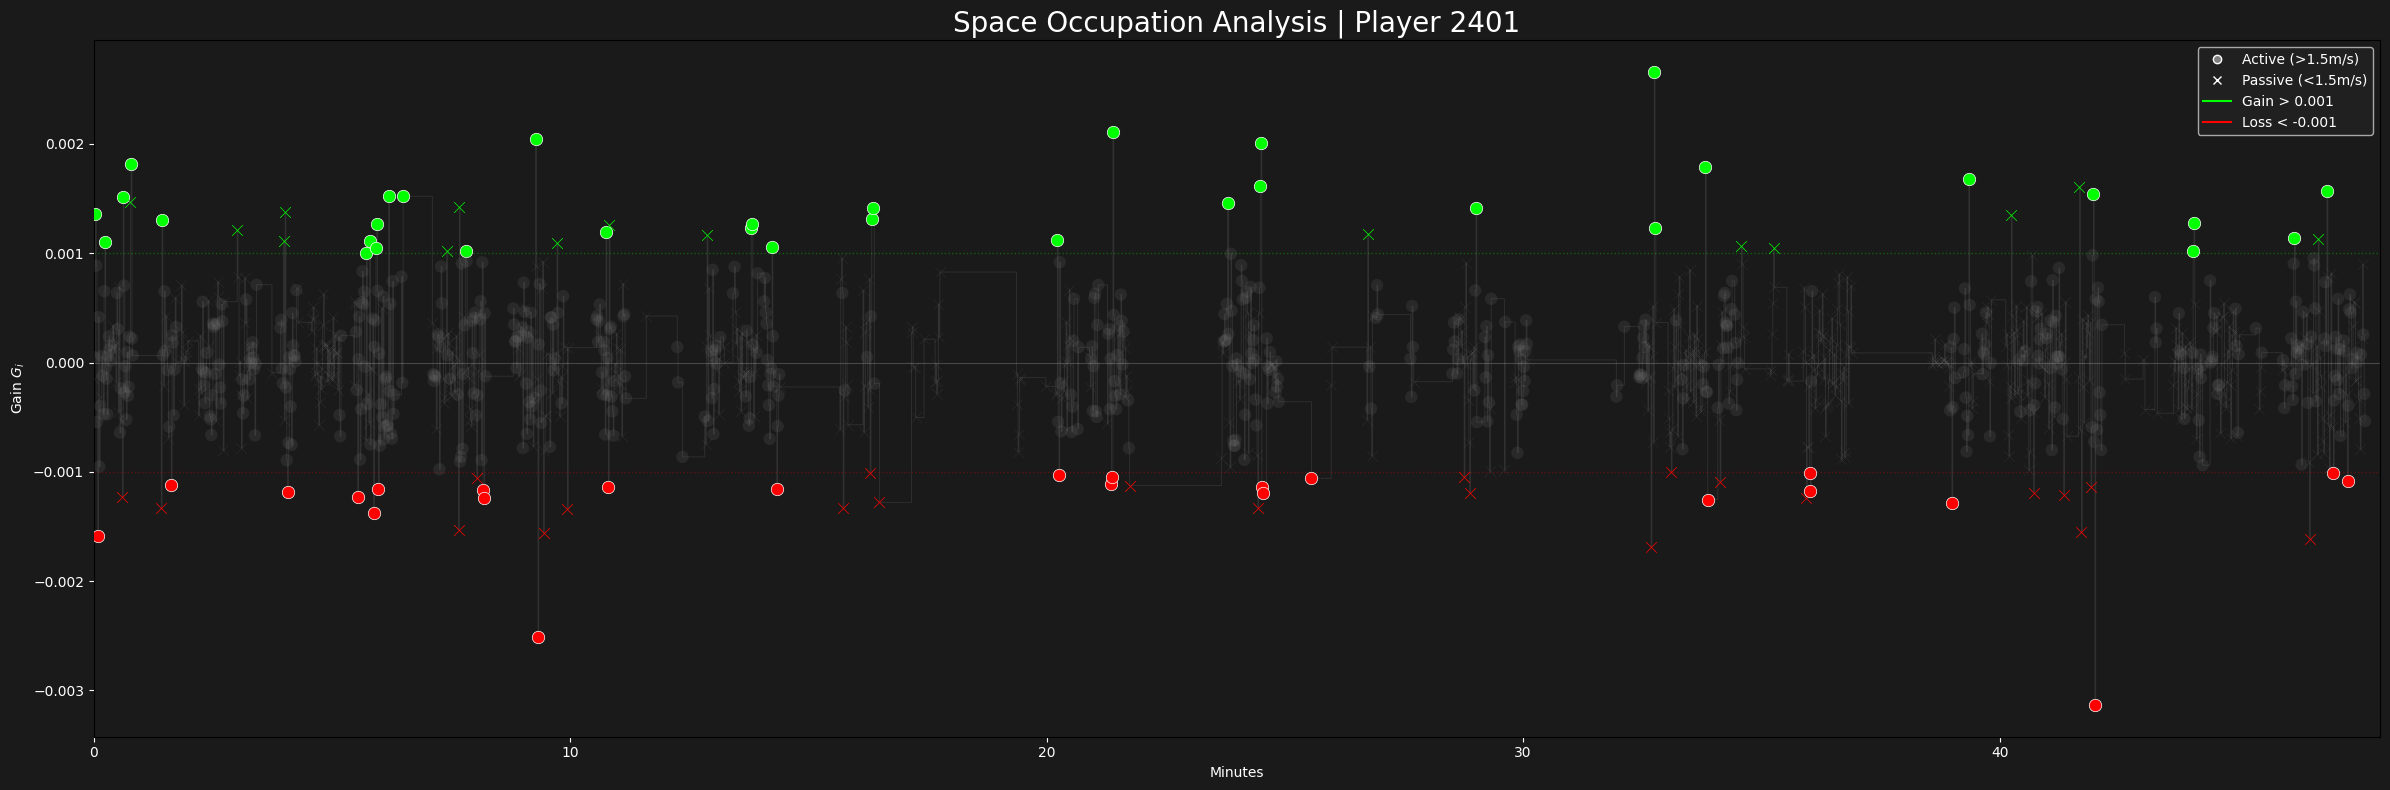

In [171]:
plot_player_sog_momentum(player_sog)

Instead of using an arbitrary fixed value 0.001, we would like to try a k-mean clustering approach to separate meaningful **signal** from **noise** in player SOGs. 

In [174]:
def find_sog_threshold_kmeans(sog_data):
    gi_values = np.array([w['gi'] for w in sog_data['windows']]).reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(gi_values)
    
    centroids = np.sort(kmeans.cluster_centers_.flatten())
    c_low, c_mid, c_high = centroids

    b_neg = (c_low + c_mid) / 2
    b_pos = (c_mid + c_high) / 2
    
    x = max(abs(b_neg), abs(b_pos))
    
    print(f"Centroids: Low={c_low:.4f}, Mid={c_mid:.4f}, High={c_high:.4f}")
    print(f"Calculated Threshold x: {x:.4f}")
    
    return x

In [173]:
x_threshold = find_sog_threshold_kmeans(player_sog)

Centroids: Low=-0.0007, Mid=0.0000, High=0.0007
Calculated Threshold x: 0.0004


### Space Generation Gain

While the concept of space occupation (SO) essentially defines the action of player actively or passively position himself in a space with increasing or decreasing quality, to evaluate his off ball movements, the space generation (SG) defines when a teammate (the Generator) pulls a defender away from another teammate (the receiver), creating space for his teammates. 

$$
SGi,i'(t) = \exists j \left( 
    (d_{i',j}(t) \leq \delta) \wedge 
    (d_{i,j}(t+w) \leq \delta) \wedge 
    (d_{i',j}(t+w) > \delta) \wedge 
    (d_{i,j}(t+w) - d_{i,j}(t) < \alpha) 
\right)
$$

The equation uses logical "AND" symbols $(∧)$ and the "There Exists" symbol $(∃)$. For Space Generation to be true, all four conditions must be met for at least one opponent:
- $(d_{i',j}(t) \leq \delta)$: At the start, the defender is close to the Receiver. (Receiver is marked).
- $(d_{i,j}(t+w) \leq \delta)$: At the end, the defender is close to the Generator. (Generator is now marked).
- $(d_{i',j}(t+w) > \delta)$: At the end, the defender is far from the Receiver. (Receiver is now free).
- $(d_{i,j}(t+w) - d_{i,j}(t) < \alpha) $: The defender actually "closed the gap" or maintained the gap with the Generator. This confirms the defender was reacting to the Generator's movement.

In [124]:
def calculate_space_generation(generator_id, team_df, opponent_df, t, w, delta=5.0, alpha=-1.0):
    sx, sy = 1.05, 0.68
    
    def get_dist_m(pos1, pos2):
        diff = (pos1 - pos2) * np.array([sx, sy])
        return np.linalg.norm(diff)

    t_w = t + w
    
    # Generator i
    gen_t = team_df[(team_df['frame'] == t) & (team_df['player'] == generator_id)]
    gen_tw = team_df[(team_df['frame'] == t_w) & (team_df['player'] == generator_id)]
    
    if gen_t.empty or gen_tw.empty:
        return []

    p_gen_t = gen_t[['x', 'y']].values[0]
    p_gen_tw = gen_tw[['x', 'y']].values[0]

    # Receivers i'
    teammates_t = team_df[team_df['frame'] == t]
    teammates_tw = team_df[team_df['frame'] == t_w]
    
    # Defenders j
    opps_t = opponent_df[opponent_df['frame'] == t]
    opps_tw = opponent_df[opponent_df['frame'] == t_w]

    sg_events = []

    other_teammates = teammates_t[teammates_t['player'] != generator_id]['player'].unique()

    for receiver_id in other_teammates:
        p_rec_t = teammates_t[teammates_t['player'] == receiver_id][['x', 'y']].values[0]
        p_rec_tw = teammates_tw[teammates_tw['player'] == receiver_id][['x', 'y']].values[0]

        for _, opp in opps_t.iterrows():
            opp_id = opp['player']
            opp_tw_row = opps_tw[opps_tw['player'] == opp_id]
            if opp_tw_row.empty: 
                continue
            
            p_opp_t = opp[['x', 'y']].values
            p_opp_tw = opp_tw_row[['x', 'y']].values[0]
            
            d_rec_opp_t = get_dist_m(p_rec_t, p_opp_t) 
            d_gen_opp_tw = get_dist_m(p_gen_tw, p_opp_tw)   
            d_rec_opp_tw = get_dist_m(p_rec_tw, p_opp_tw) 
            d_gen_opp_t = get_dist_m(p_gen_t, p_opp_t)
            attraction_diff = d_gen_opp_tw - d_gen_opp_t

            if (d_rec_opp_t <= delta) and \
               (d_gen_opp_tw <= delta) and \
               (d_rec_opp_tw > delta) and \
               (attraction_diff < alpha):
                
                sg_events.append({
                    'receiver_id': receiver_id,
                    'defender_id': opp_id,
                    'attraction_value': attraction_diff  
                })
                
    return sg_events

In [ ]:
def analyze_player_sg(player_id, df_home_players, df_away_players, df_ball, 
                                   w=50, delta=5.0, alpha=-1.0):
    if player_id in df_home_players['player'].unique():
        p_team, team_df, opponent_df = 'home', df_home_players, df_away_players
    else:
        p_team, team_df, opponent_df = 'away', df_away_players, df_home_players

    window_starts = get_valid_window_starts(df_ball, p_team, w)
    
    if len(window_starts) == 0:
        return pd.DataFrame()
    
    sg_results = []
    print(f"Analyzing Space Generation for Player {player_id}: {len(window_starts)} windows...")

    for t in window_starts:
        row_ball = df_ball[df_ball['frame'] == t]
        if not row_ball.empty and row_ball['possession_team'].values[0] == p_team:
            try:
                events = calculate_space_generation(player_id, team_df, opponent_df, t, w, delta, alpha)
                if events:
                    for e in events:
                        sg_results.append({
                            'frame': t,
                            'generator_id': player_id,
                            'receiver_id': e['receiver_id'],
                            'defender_id': e['defender_id'],
                            'attraction': e['attraction_value']
                        })
            except:
                continue
                
    return pd.DataFrame(sg_results)

In [ ]:
DELTA = 5  # Max marking distance (meters)
ALPHA = -1 # Minimum attraction (meters)
WINDOW = 50  # Time window （frames)

sg_df = analyze_player_sg(
    player_id=2401, 
    df_home_players=df_home_players, 
    df_away_players=df_away_players, 
    df_ball=df_ball, 
    w=WINDOW, 
    delta=DELTA, 
    alpha=ALPHA
)

Analyzing Space Generation for Player 2401: 2411 windows...


Now, we can preview how many time a specified player has generated space to his teammates throughout a game. 

In [160]:
print(sg_df)

     frame  generator_id  receiver_id  defender_id  attraction
0      100          2401         2237         2309   -1.359996
1      150          2401         2237         2319   -4.187867
2     2250          2401         2405         2261   -2.324219
3     4877          2401         2227         2315   -1.173002
4     7999          2401         2405         2339   -1.283257
5    17369          2401         2247         2261   -2.055699
6    18618          2401         2405         2311   -1.405716
7    18818          2401         2237         2307   -3.916081
8    18918          2401         2227         2319   -4.400608
9    18918          2401         2227         2339   -1.912741
10   19376          2401         2405         2339   -3.265908
11  103525          2401         2227         2319   -1.263932
12  110484          2401         2405         2339   -1.366371
13  116835          2401         2353         2323   -1.412284
14  118166          2401         2267         2367   -1

In [146]:
def plot_sg_momentum(sg_df, player_id, p_start_frame, p_end_frame, fps=50):
    """
    Plots the Space Generation events over time.
    """
    if sg_df.empty:
        return print("No Space Generation events detected for this player.")

    sg_df['minutes'] = sg_df['frame'] / (fps * 60.0)
    
    plt.figure(figsize=(32, 6), facecolor='#1a1a1a')
    ax = plt.gca()
    ax.set_facecolor('#1a1a1a')

    plt.vlines(sg_df['minutes'], 0, sg_df['attraction'] * -1, color='cyan', alpha=0.3, linewidth=1)
    
    scatter = plt.scatter(
        sg_df['minutes'], 
        sg_df['attraction'] * -1, 
        c=sg_df['attraction'] * -1, 
        cmap='winter', 
        s=100, 
        edgecolor='white', 
        zorder=3
    )
    plt.axhline(0, color='white', alpha=0.3)
    plt.xlim(p_start_frame / (fps * 60.0), p_end_frame / (fps * 60.0))
    
    plt.title(f"Space Generation Momentum | Player {player_id}", color='white', fontsize=20)
    plt.xlabel("Match Time (Minutes)", color='white')
    plt.ylabel("Attraction Intensity (|α|)", color='white')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Dragging Intensity', color='white')
    cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')

    plt.tick_params(colors='white')
    plt.grid(axis='y', color='white', alpha=0.05)
    plt.show()

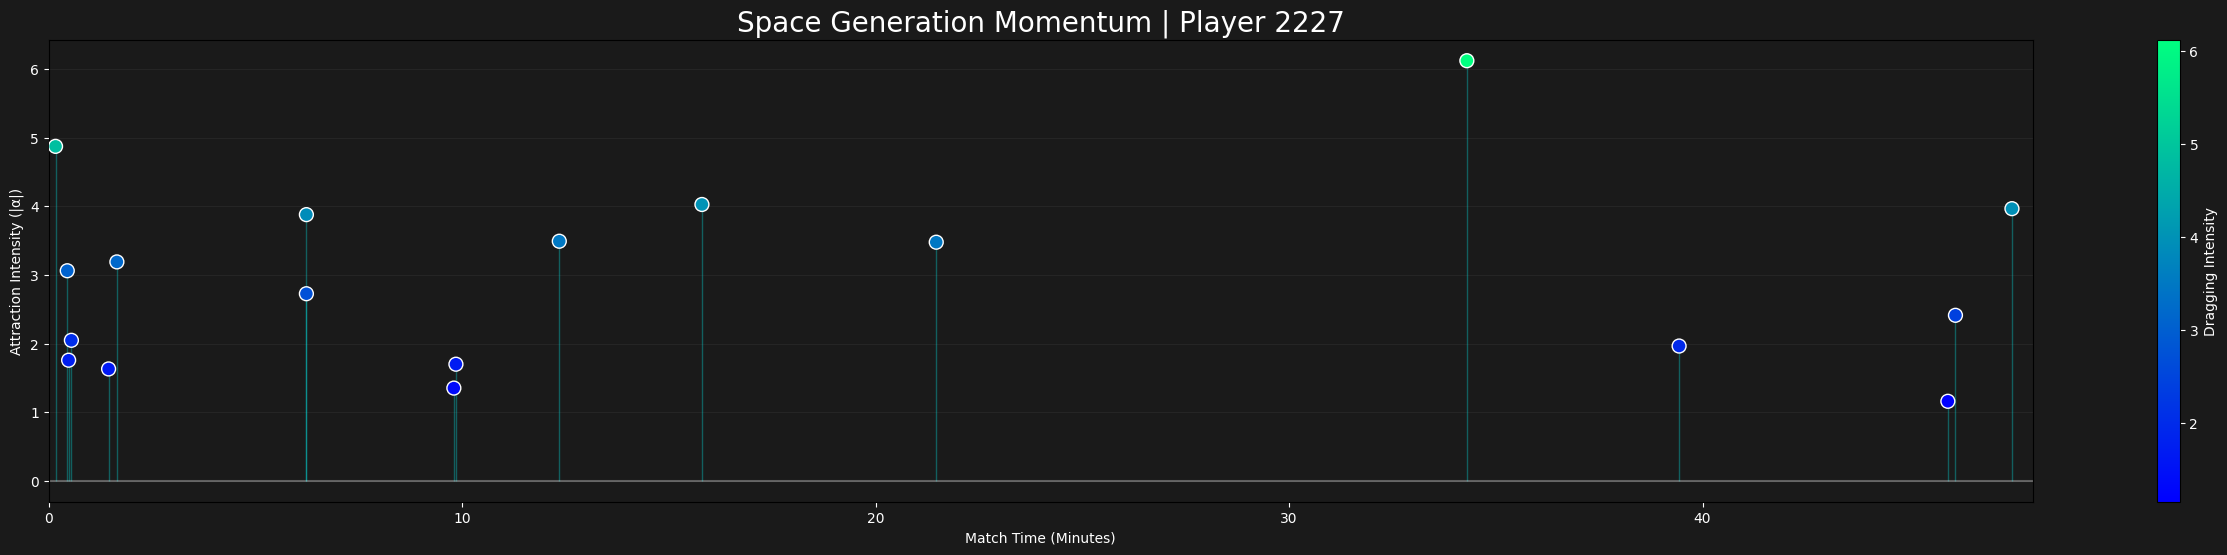

In [147]:
player_frames = df_home_players[df_home_players['player'] == 2227]['frame']
start_f, end_f = player_frames.min(), player_frames.max()

plot_sg_momentum(
    sg_df=sg_df, 
    player_id=2227, 
    p_start_frame=start_f, 
    p_end_frame=end_f, 
    fps=50
)

In [175]:
def plot_sg_event_analysis(event_idx, sg_df, w, team_df, opponent_df, df_ball, model, pc_grid, device):
    event = sg_df.iloc[event_idx]
    t = int(event['frame'])
    t_w = t + w
    gen_id = int(event['generator_id'])
    rec_id = int(event['receiver_id'])
    
    defenders = sg_df[(sg_df['frame'] == t) & 
                     (sg_df['generator_id'] == gen_id) & 
                     (sg_df['receiver_id'] == rec_id)]['defender_id'].unique().tolist()

    frames = [t, t_w]
    sx, sy = 1.05, 0.68 # Wyscout scaling
    
    ball_data = df_ball[df_ball['frame'].isin(frames)].set_index('frame')
    ball_inputs = torch.tensor(ball_data[['x', 'y']].values, dtype=torch.float32).to(device)
    with torch.no_grad():
        V_raw = model(ball_inputs).reshape(2, 1, 15, 21)
        V_batch = F.interpolate(V_raw, size=pc_grid.shape[:2], mode='bilinear', align_corners=True).squeeze(1).cpu().numpy()

    pitch = Pitch(pitch_type='wyscout', line_color='#7c7c7c', goal_type='box', pitch_color='#1a1a1a')
    fig, axes = plt.subplots(1, 2, figsize=(22, 10), facecolor='#1a1a1a')
    X, Y = np.meshgrid(np.linspace(0, 100, pc_grid.shape[1]), np.linspace(0, 100, pc_grid.shape[0]))

    for i, f in enumerate(frames):
        ax = axes[i]
        pitch.draw(ax=ax)
        ax.set_aspect(68/105) 
        
        pc_surf = compute_team_pitch_control(
            team_df[team_df['frame'] == f], 
            opponent_df[opponent_df['frame'] == f], 
            ball_data.loc[f, ['x', 'y']].values, 
            pc_grid, sx=sx, sy=sy
        )
        
        q_surf = pc_surf * V_batch[i]
        
        extent = [0, 100, 0, 100]
        img = ax.imshow(q_surf, extent=extent, origin='lower', 
                        cmap='magma', alpha=0.8, zorder=0, aspect=0.64)

        pitch.scatter(opponent_df[opponent_df['frame']==f].x, opponent_df[opponent_df['frame']==f].y, 
                      s=70, c='#00E5FF', edgecolors='white', ax=ax, alpha=0.6, zorder=2)
        
        pitch.scatter(team_df[team_df['frame']==f].x, team_df[team_df['frame']==f].y, 
                      s=70, c='#FF4B4B', edgecolors='white', ax=ax, alpha=0.6, zorder=2)

        # 1. Generator (Lime)
        p_gen = team_df[(team_df['frame'] == f) & (team_df['player'] == gen_id)].iloc[0]
        pitch.scatter(p_gen.x, p_gen.y, s=80, c='#FF4B4B', edgecolors='white', ax=ax, zorder=14)
        pitch.scatter(p_gen.x, p_gen.y, s=500, facecolors='none', edgecolors='lime', linewidth=3, ax=ax, zorder=15)

        # 2. Receiver (Yellow)
        p_rec = team_df[(team_df['frame'] == f) & (team_df['player'] == rec_id)].iloc[0]
        pitch.scatter(p_rec.x, p_rec.y, s=80, c='#FF4B4B', edgecolors='white', ax=ax, zorder=14)
        pitch.scatter(p_rec.x, p_rec.y, s=500, facecolors='none', edgecolors='yellow', linewidth=3, ax=ax, zorder=15)

        # 3. Defender(s) (White)
        for d_id in defenders:
            p_def_row = opponent_df[(opponent_df['frame'] == f) & (opponent_df['player'] == d_id)]
            if not p_def_row.empty:
                p_def = p_def_row.iloc[0]
                pitch.scatter(p_def.x, p_def.y, s=80, c='#00E5FF', edgecolors='white', ax=ax, zorder=14)
                pitch.scatter(p_def.x, p_def.y, s=500, facecolors='none', edgecolors='white', linewidth=2, linestyle='--', ax=ax, zorder=15)

        pitch.scatter(ball_data.loc[f].x, ball_data.loc[f].y, s=60, c='white', edgecolors='black', ax=ax, zorder=20)
        
        title_suffix = "START (t)" if i == 0 else "END (t+w)"
        ax.set_title(f"{title_suffix}\nFrame: {f}", color='white', fontsize=16)

    plt.suptitle(f"Space Generation: Generator {gen_id} → Receiver {rec_id}", color='white', fontsize=22, y=0.98)
    plt.tight_layout()
    
    plt.show()

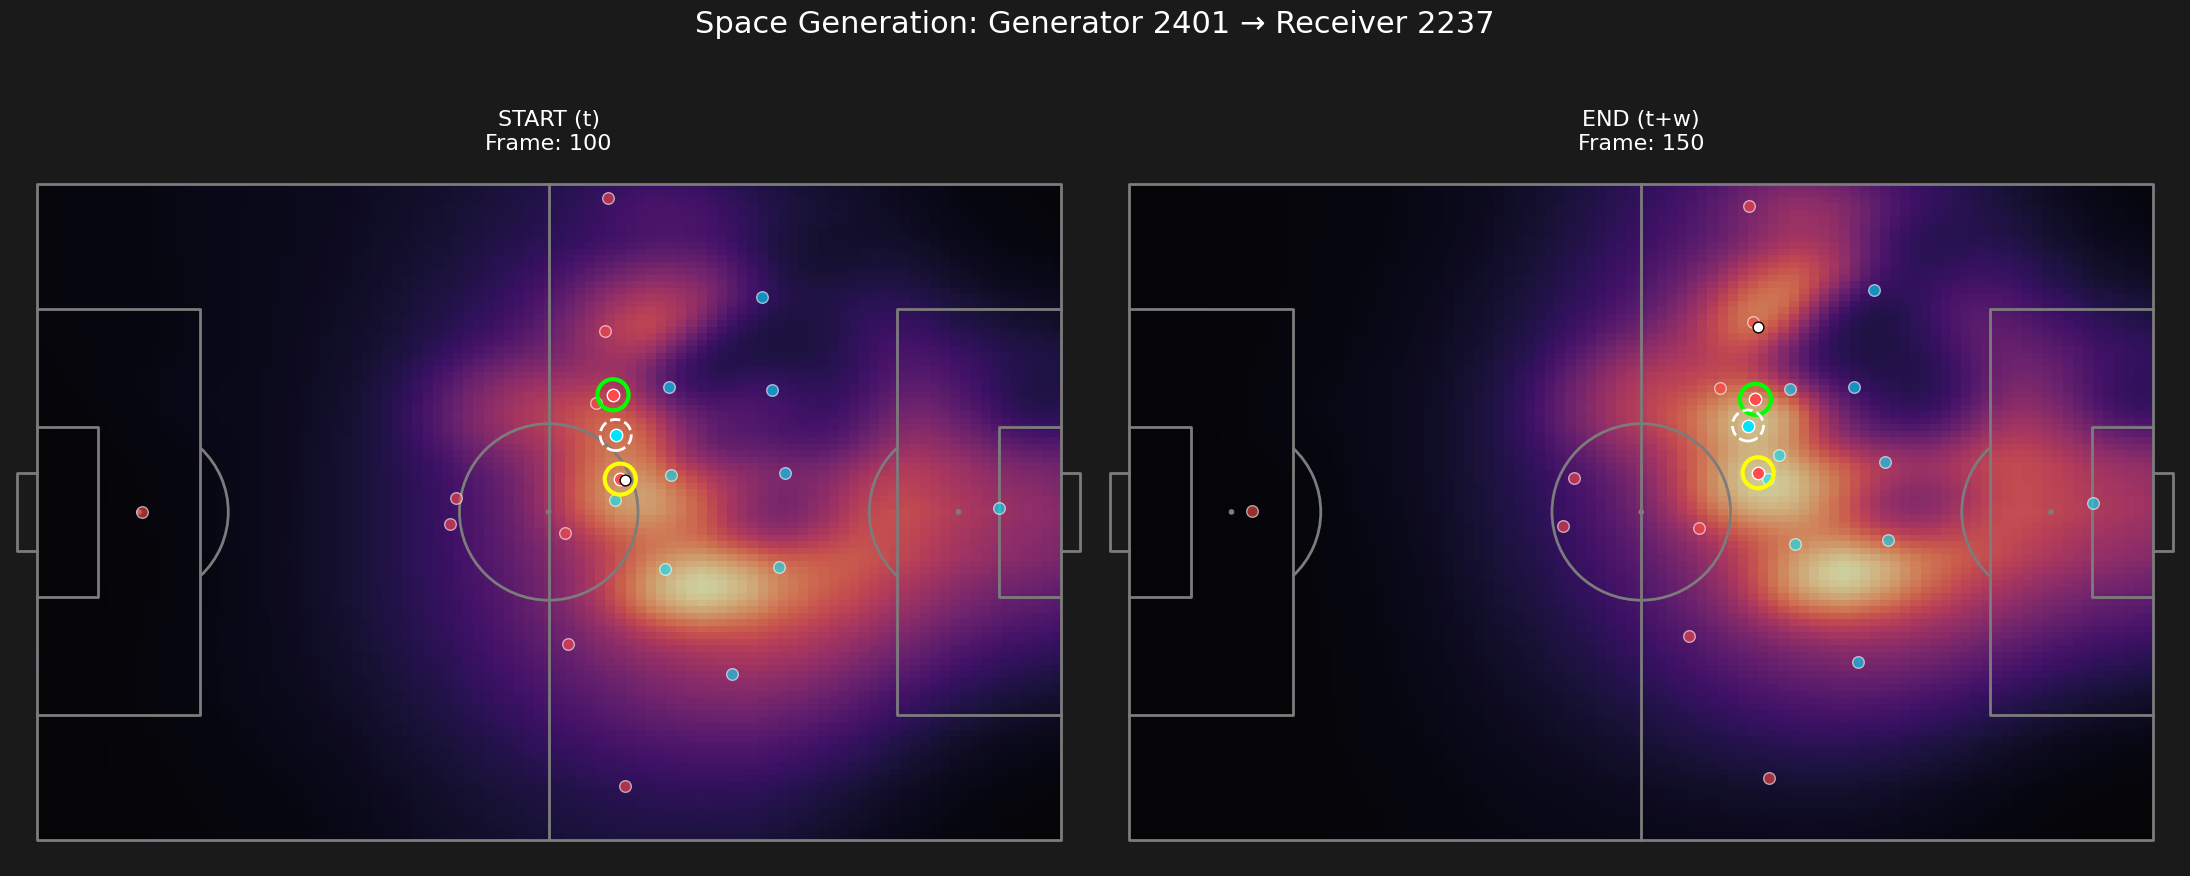

In [176]:
plot_sg_event_analysis(0, sg_df, w=50, team_df=df_home_players, 
                       opponent_df=df_away_players, df_ball=df_ball, 
                       model=model, pc_grid=pc_grid_3d, device=device)

$$
SGG_{i,j}(t) = \begin{cases} G_j(t) & \text{if } SG_{i,j}(t) \wedge G_j(t) \geq \epsilon \\ 0 & \text{otherwise} \end{cases}
$$

This equation defines the Space Generation Gain (SGG) for a specific player at a given time. It calculates the "Gain" ($G_j$) in space value, but only if the player is actually performing a "Space Generation" ($SG$) action

In [ ]:
def generate_team_sgg_matrix(team_players_ids, team_df, opponent_df, df_ball, 
                             model, pc_grid, device, 
                             w=50, delta=10.0, alpha=-0.3, epsilon=0.0004):
    n = len(team_players_ids)
    matrix = np.zeros((n, n))
    player_to_idx = {p_id: i for i, p_id in enumerate(team_players_ids)}
    
    print(f"Generating SGG Matrix for {n} players...")

    for gen_id in team_players_ids:
        # 1. Find all SG events where gen_id is the generator
        sg_events = analyze_player_sg(
            gen_id, team_df, opponent_df, df_ball, 
            w=w, delta=delta, alpha=alpha
        )
        
        if sg_events.empty:
            continue
            
        for _, row in sg_events.iterrows():
            t = int(row['frame'])
            rec_id = int(row['receiver_id'])
            
            if rec_id not in team_players_ids:
                continue 

            try:
                gj = calculate_individual_G(rec_id, team_df, opponent_df, t, w, 
                                            model, df_ball, device, pc_grid)
                
                if gj >= epsilon:
                    gen_idx = player_to_idx[gen_id]
                    rec_idx = player_to_idx[rec_id]
                    matrix[gen_idx, rec_idx] += 1
                    
            except ValueError:
                continue
                
    return pd.DataFrame(matrix, index=team_players_ids, columns=team_players_ids)

In [178]:
home_ids = [2401, 2267, 2353, 2227, 2405, 2247]
sgg_matrix = generate_team_sgg_matrix(home_ids, df_home_players, df_away_players, 
                                      df_ball, model, pc_grid_3d, device)

Generating SGG Matrix for 6 players...
Analyzing Space Generation for Player 2401: 2411 windows...
Analyzing Space Generation for Player 2267: 2411 windows...
Analyzing Space Generation for Player 2353: 2411 windows...
Analyzing Space Generation for Player 2227: 2411 windows...
Analyzing Space Generation for Player 2405: 2411 windows...
Analyzing Space Generation for Player 2247: 2411 windows...


In [ ]:
def plot_sgg_heatmap_focused(matrix_df):
    plt.figure(figsize=(10, 8), facecolor='#1a1a1a')
    
    ax = sns.heatmap(
        matrix_df, 
        annot=True, 
        fmt=".0f", 
        cmap='YlOrRd', 
        linewidths=1.5, 
        linecolor='#1a1a1a',
        cbar_kws={'label': 'Successful SGG Events'}
    )
    
    plt.title("Attacking Core Synergy: Space Generation Gain", color='white', fontsize=18, pad=20)
    plt.xlabel("Receiver (The Beneficiary)", color='white', fontsize=12)
    plt.ylabel("Generator (The Decoy)", color='white', fontsize=12)
    
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    plt.show()

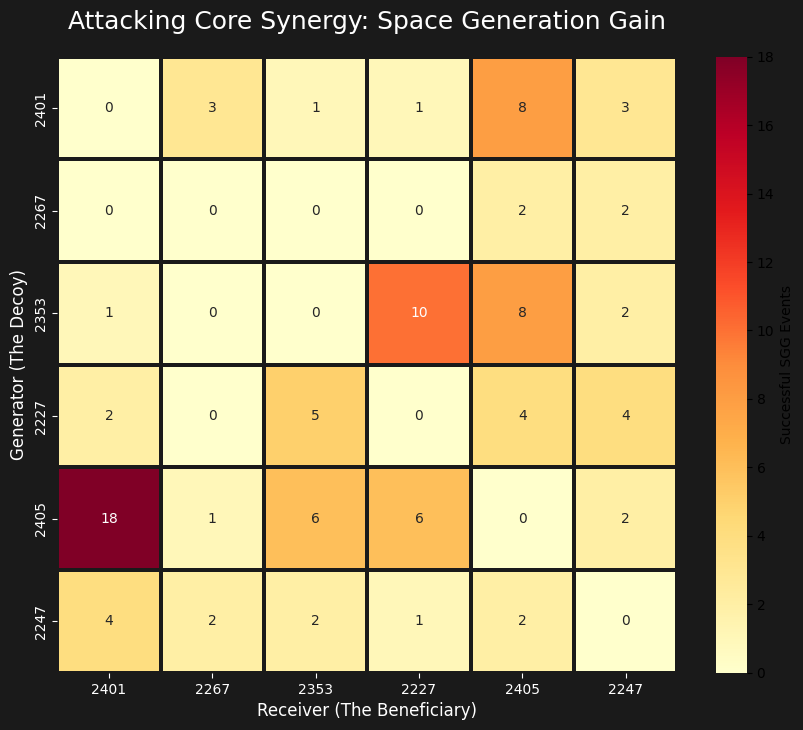

In [179]:
plot_sgg_heatmap_focused(sgg_matrix)

The heatmap shows how effectively attacking players are working together to create space. It moves beyond simple passing stats to show **"off-ball"** impact.

**Key Tactical Insights**
- The Primary Synergy (2405 → 2401): Player `2405` is the team's most effective "space maker" for Player `2401`. With 18 recorded events, this pairing represents the strongest attacking link in the core. When `2405` moves, `2401` almost always finds open grass.
- The Self-Sacrificing Playmaker (2353 → 2227): Player `2353` shows a high synergy with `2227` (10 events) and `2405` (8 events). This suggests `2353` is excellent at identifying which teammate needs space and making the specific decoy runs to provide it.
- The Focal Point (2401): Looking vertically down the first column, Player `2401` is the most frequent beneficiary overall. The team’s tactical structure seems designed to "open up" the pitch specifically for `2401`.
- Isolated Connections: Player `2267` appears relatively disconnected in this specific "Space Generation" phase, acting as neither a major decoy nor a major beneficiary.